In [1]:
import pandas as pd
import numpy as np
import os
import re
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

# Prediction based on AGE

## Pre-processing

### Functions for pre-processing

In [2]:
def index_pre_process(dataframe, pattern, pattern_1):
    '''
    Pre-processing involves following steps:
    1. Transpose, such that state codes are columns, and age category is indexes
    2. Add population of all state codes to a single column for each category.
    3. Keep the total population including male and female for each age category
    4. Here we have 0,1,2,3,4 age categories and 0-4 age categories, we will delete indexes of 0,1,2,3,4, since
    0-4 is same and this will be easier with less data but same information
    '''
    
    # Transpose step
    dataframe_copy = dataframe.T.copy()
    
    # New column with total sum
    dataframe_copy['total_sum'] = pd.Series(np.sum(dataframe_copy, axis=1))
    
    # removal of all other columns except for 'total sum column'
    dataframe_copy.drop(labels = (list(dataframe_copy.columns))[:-1], axis = 1, inplace = True)
    
    # removal of indexes with 'M' or 'F' and only '0 to 4' kind of categories
    index_list = list(dataframe_copy.index)
#     updated_index_list = [words for words in index_list
#                           if ('M' not in words) & ('F' not in words) & (len(re.findall(pattern = pattern, string = words)) > 0) & (len(re.findall(pattern = pattern_1, string = words)) == 0)]

    updated_index_list = [words for words in index_list
                          if ('M' not in words) & ('F' not in words) & ((len(re.findall(pattern = pattern, string = words)) > 0) | (len(re.findall(pattern = pattern_1, string = words)) > 0))]


    dataframe_copy = dataframe_copy.loc[updated_index_list, :]
    
    return dataframe_copy
    

In [3]:
def get_dataframe(path, file_location_1, file_location_2, file_location_3, file_location_4, file_location_5):
    '''
    1. Get the 5 files and combine the dataframe
    2. Use a pattern to get the categories as per requirement
    3. Combine 5 dataframes
    4. Removal of data not as per requirements
    '''
    # creating dataframes
    age_file_df_1 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_1), index_col = 0)
    age_file_df_2 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_2), index_col = 0)
    age_file_df_3 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_3), index_col = 0)
    age_file_df_4 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_4), index_col = 0)
    age_file_df_5 = pd.read_csv(filepath_or_buffer = os.path.join(path, file_location_5), index_col = 0)
    
    # using other definition
    pattern = '_[0-9]+_'
    pattern_1 = '_[0-9]+[a-z]+_'
    age_df_1 = index_pre_process(dataframe = age_file_df_1, pattern = pattern, pattern_1 = pattern_1)
    age_df_2 = index_pre_process(dataframe = age_file_df_2, pattern = pattern, pattern_1 = pattern_1)
    age_df_3 = index_pre_process(dataframe = age_file_df_3, pattern = pattern, pattern_1 = pattern_1)
    age_df_4 = index_pre_process(dataframe = age_file_df_4, pattern = pattern, pattern_1 = pattern_1)
    age_df_5 = index_pre_process(dataframe = age_file_df_5, pattern = pattern, pattern_1 = pattern_1)
    
    # contcat all the dataframes
    age_df_combined = pd.concat([age_df_1, age_df_2,age_df_3,age_df_4,age_df_5], axis = 0)
    
    # remove dates like 0_to_4
    age_df_combined_index = list(age_df_combined.index)
    pattern_2 = '_[0-9]+_[0-9]+_'
    updated_index_list_1 = [word for word in age_df_combined_index
                            if len(re.findall(pattern = pattern_2, string = word)) == 0]
    age_df_combined = age_df_combined.loc[updated_index_list_1,:]
    
    return age_df_combined

### Pre-processing steps
* Age is devided into following categories:
    * under18
    * 18-24
    * 25-34
    * 35-44
    * 45-54
    * 55-64
    * 65 and older

In [4]:
# files for age category and main directory path
direcotry_path = '2016_TSP_STE_for_NSW_short-header/2016 Census TSP States and Territories for NSW/'
file_path_1 = '2016Census_T03A_NSW_STE.csv'
file_path_2 = '2016Census_T03B_NSW_STE.csv'
file_path_3 = '2016Census_T03C_NSW_STE.csv'
file_path_4 = '2016Census_T03D_NSW_STE.csv'
file_path_5 = '2016Census_T03E_NSW_STE.csv'

# calling function to get the dataframe
df = get_dataframe(
                        path = direcotry_path,
                        file_location_1 = file_path_1,
                        file_location_2 = file_path_2,
                        file_location_3 = file_path_3,
                        file_location_4 = file_path_4,
                        file_location_5 = file_path_5
)

# get the required index and dates, df['year'] column will give year = 06 or 11 or 16
df_index = list(df.index)
df['year'] = [words[-4:-2] for words in df_index]

# extracting categories according to years 06, 11, 16
index_list_06 = [data for data in df_index
                 if df.loc[data,'year'] == '06']
index_list_11 = [data for data in df_index
                 if df.loc[data,'year'] == '11']
index_list_16 = [data for data in df_index
                 if df.loc[data,'year'] == '16']
df_06 = df.loc[index_list_06, :]
df_11 = df.loc[index_list_11, :]
df_16 = df.loc[index_list_16, :]
df_06_index = df_06.index

### GET VALUES as per AGE CATEGORY in REQUIREMENTS
# under 18
zero_18_06 = np.sum(df_06.iloc[:19, 0])
zero_18_11 = np.sum(df_11.iloc[:19, 0])
zero_18_16 = np.sum(df_16.iloc[:19, 0])

# 18 to 25
zero_19_24_06 = np.sum(df_06.iloc[19:25, 0])
zero_19_24_11 = np.sum(df_11.iloc[19:25, 0])
zero_19_24_16 = np.sum(df_16.iloc[19:25, 0])

# 25 to 34
zero_25_34_06 = np.sum(df_06.iloc[25:35, 0])
zero_25_34_11 = np.sum(df_11.iloc[25:35, 0])
zero_25_34_16 = np.sum(df_16.iloc[25:35, 0])

# 35 to 44
zero_35_44_06 = np.sum(df_06.iloc[35:45, 0])
zero_35_44_11 = np.sum(df_11.iloc[35:45, 0])
zero_35_44_16 = np.sum(df_16.iloc[35:45, 0])

# 45 to 54
zero_45_54_06 = np.sum(df_06.iloc[45:55, 0])
zero_45_54_11 = np.sum(df_11.iloc[45:55, 0])
zero_45_54_16 = np.sum(df_16.iloc[45:55, 0])

# 55 to 64
zero_55_64_06 = np.sum(df_06.iloc[55:65, 0])
zero_55_64_11 = np.sum(df_11.iloc[55:65, 0])
zero_55_64_16 = np.sum(df_16.iloc[55:65, 0])

# 65 above
zero_65_ab_06 = np.sum(df_06.iloc[65:, 0])
zero_65_ab_11 = np.sum(df_11.iloc[65:, 0])
zero_65_ab_16 = np.sum(df_16.iloc[65:, 0])

# creating a dataframe as per categories
age_df = pd.DataFrame()
age_df['2006_data'] = pd.Series([zero_18_06, zero_19_24_06, zero_25_34_06, zero_35_44_06, zero_45_54_06, zero_55_64_06, zero_65_ab_06])
age_df['2011_data'] = pd.Series([zero_18_11, zero_19_24_11, zero_25_34_11, zero_35_44_11, zero_45_54_11, zero_55_64_11, zero_65_ab_11])
age_df['2016_data'] = pd.Series([zero_18_16, zero_19_24_16, zero_25_34_16, zero_35_44_16, zero_45_54_16, zero_55_64_16, zero_65_ab_16])

age_df.index = ['below 18 years', '18 to 25', '25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 above']

# transposing the dataframe and adding the dates index, along with preparing dataframe for regression
age_df_transposed = age_df.T
age_df_transposed.index = ['2006', '2011', '2016']
# age_df_transposed.index = pd.DatetimeIndex(data = age_df_transposed.index)
age_df_transposed['Dates'] = age_df_transposed.index
age_df_transposed.index = ['1', '2','3']

# calculating total population along with individual age categories
age_df_transposed['total_population'] = np.sum(age_df_transposed.iloc[:,:-1], axis = 1)
cols = list(age_df_transposed.columns)
a, b = cols.index('total_population'), cols.index('Dates')
cols[b], cols[a] = cols[a], cols[b]
age_df_transposed = age_df_transposed[cols]
age_df_transposed

,below 18 years,18 to 25,25 to 34,35 to 44,45 to 54,55 to 64,65 above,total_population,Dates
1,1653876,516768,891047,957844,904337,719539,765073,6408484,2006
2,1688546,537074,941508,971638,950456,810292,867459,6766973,2011
3,1742488,581935,1067528,1002882,977983,889760,1061819,7324395,2016


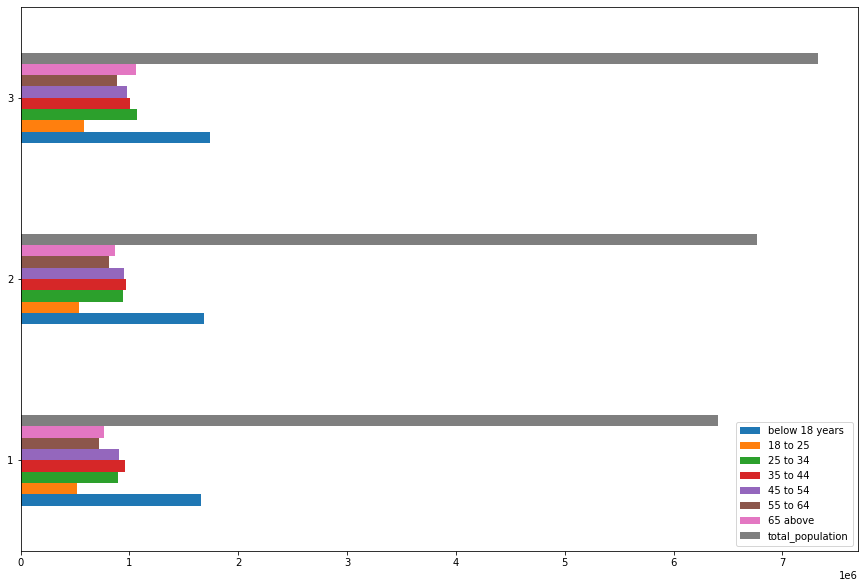

In [5]:
age_df_transposed.plot(kind = 'barh', figsize = (15,10))

## Regression models

In [6]:
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, SGDRegressor, PoissonRegressor

In [7]:
def model_results(model, age_df_transposed, column):
    '''
    This function will get the regression result for a regression model for a single category
    '''
    X = (age_df_transposed.index).values
    y = age_df_transposed.iloc[:,column].values
    X = X.reshape(-1,1)
    y = y.reshape(-1,1)
    column_names = age_df_transposed.columns
    model.fit(X, y)
    X_test = ['4','5','6']
    X_test = np.array(X_test, dtype = 'object')
    X_test = X_test.reshape(-1,1)
    prediction = model.predict(X_test)
    prediction = [value  if (value>0) else 0 for value in prediction]
    plt.bar(['2006', '2011', '2016','2021', '2026', '2031'], np.append(age_df_transposed.iloc[:,column].values,prediction))
    plt.title(column_names[column])
    plt.show()
    return prediction

def create_dataframe(model, dataframe, cols):
    '''
    This function will call the model results function and get the model results for all categories and 
    create a dataframe
    '''
    prediction_results_partial = []
    prediction_results_nested = []
    prediction_dates = ['2021', '2026', '2031']
    for i in range(len(cols[:-1])):
        prediction_results_partial.append(model_results(model,
                                                        age_df_transposed = dataframe,
                                                        column = i))
        prediction_results_nested.append(prediction_results_partial)
        prediction_results_partial = []
    new_df = pd.DataFrame()
    for i in range(len(prediction_results_nested)):
        new_df[i] = pd.Series(np.hstack(prediction_results_nested[i][0]))
    new_df.index = prediction_dates
    column_names = dataframe.columns
    new_df.columns = cols[:-1]
    return new_df

def reset_df(age_df):
    '''
    This function will reset the index of dataframe as required by regression function
    '''
    age_df_transposed = age_df.T
    age_df_transposed.index = ['2006', '2011', '2016']
    # age_df_transposed.index = pd.DatetimeIndex(data = age_df_transposed.index)
    age_df_transposed['Dates'] = age_df_transposed.index
    age_df_transposed.index = ['1', '2','3']
    age_df_transposed['total_population'] = np.sum(age_df_transposed.iloc[:,:-1], axis = 1)
    cols = list(age_df_transposed.columns)
    a, b = cols.index('total_population'), cols.index('Dates')
    cols[b], cols[a] = cols[a], cols[b]
    age_df_transposed = age_df_transposed[cols]
    return age_df_transposed, cols

### Linear Regression

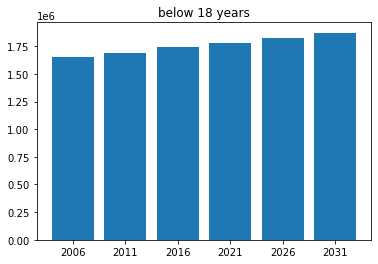

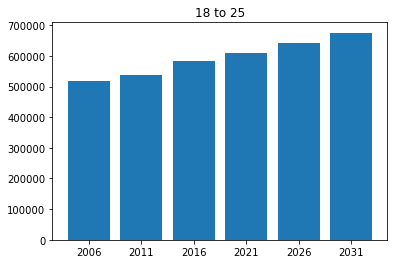

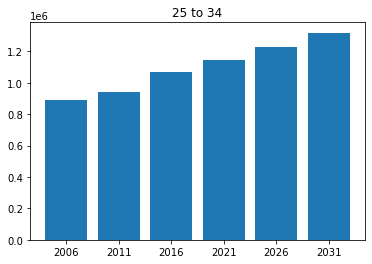

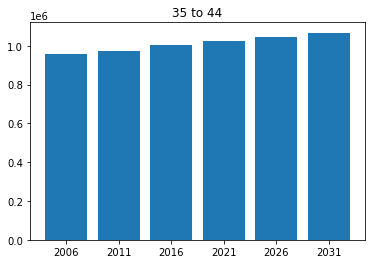

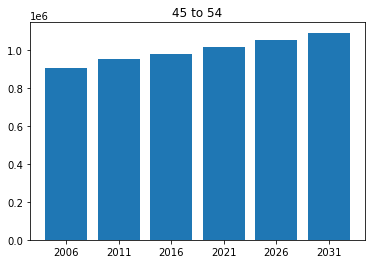

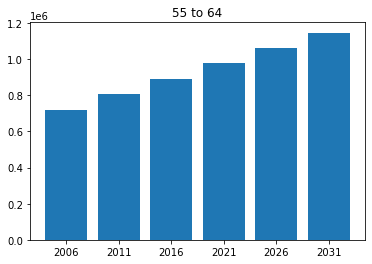

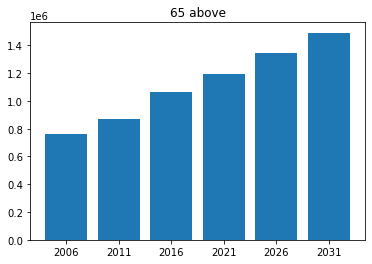

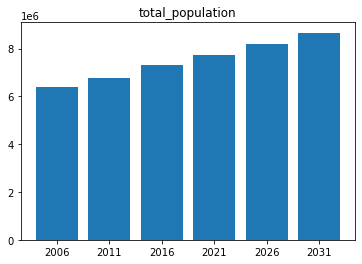

In [8]:
age_df_transposed, cols = reset_df(age_df = age_df)
model = LinearRegression()
linear_prediction_df = create_dataframe(model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_linear_results_age = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), linear_prediction_df])

In [9]:
df_with_linear_results_age = df_with_linear_results_age.add_suffix('_linear_model')
df_with_linear_results_age

,below 18 years_linear_model,18 to 25_linear_model,25 to 34_linear_model,35 to 44_linear_model,45 to 54_linear_model,55 to 64_linear_model,65 above_linear_model,total_population_linear_model
2006,1653876.0,516768.0,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,765073.0,6408484.0
2011,1688546.0,537074.0,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,867459.0,6766973.0
2016,1742488.0,581935.0,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1061819.0,7324395.0
2021,1783582.0,610426.0,1.143175e+06,1.022493e+06,1.017905e+06,9.767513e+05,1194863.0,7749195.0
2026,1827888.0,643009.5,1.231416e+06,1.045012e+06,1.054728e+06,1.061862e+06,1343236.0,8207150.5
2031,1872194.0,675593.0,1.319656e+06,1.067531e+06,1.091551e+06,1.146972e+06,1491609.0,8665106.0


### Huber Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


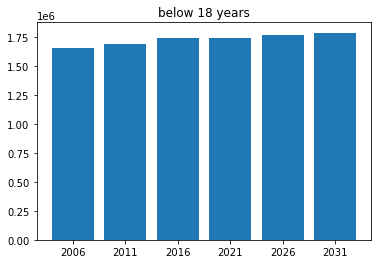

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


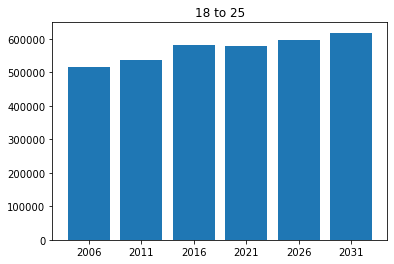

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


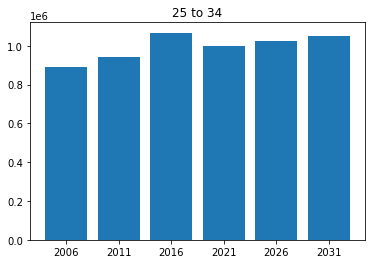

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


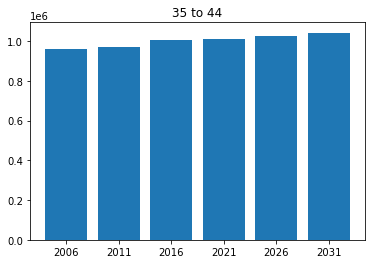

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


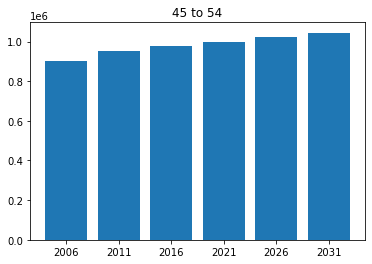

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


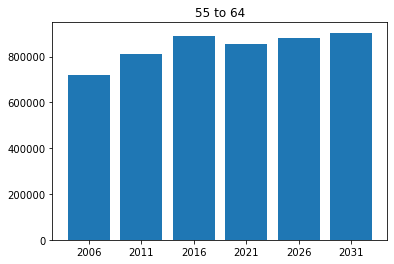

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


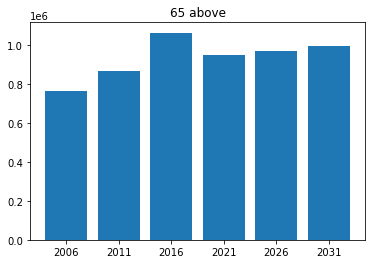

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


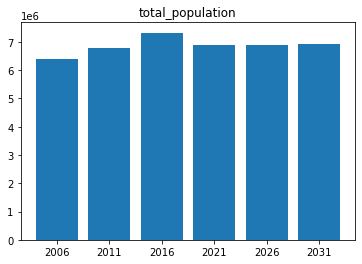

In [10]:
age_df_transposed, cols = reset_df(age_df = age_df)
huber_model = HuberRegressor()
huber_prediction_df = create_dataframe(huber_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_huber_results_age = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), huber_prediction_df])

In [11]:
df_with_huber_results_age = df_with_huber_results_age.add_suffix('_huber_model')
df_with_huber_results_age

,below 18 years_huber_model,18 to 25_huber_model,25 to 34_huber_model,35 to 44_huber_model,45 to 54_huber_model,55 to 64_huber_model,65 above_huber_model,total_population_huber_model
2006,1.653876e+06,516768.000000,8.910470e+05,9.578440e+05,9.043370e+05,719539.000000,7.650730e+05,6.408484e+06
2011,1.688546e+06,537074.000000,9.415080e+05,9.716380e+05,9.504560e+05,810292.000000,8.674590e+05,6.766973e+06
2016,1.742488e+06,581935.000000,1.067528e+06,1.002882e+06,9.779830e+05,889760.000000,1.061819e+06,7.324395e+06
2021,1.740921e+06,577738.905809,1.000594e+06,1.008841e+06,9.967112e+05,855449.615679,9.460281e+05,6.881850e+06
2026,1.764820e+06,598059.030736,1.024493e+06,1.025443e+06,1.020610e+06,879909.256289,9.699836e+05,6.906133e+06
2031,1.788718e+06,618379.155664,1.048392e+06,1.042044e+06,1.044508e+06,904368.896900,9.939392e+05,6.930416e+06


### RANSAC Regression

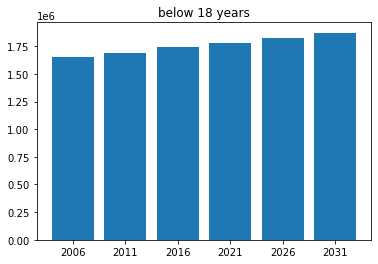

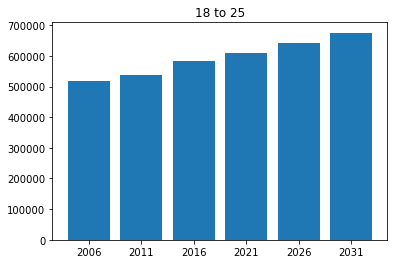

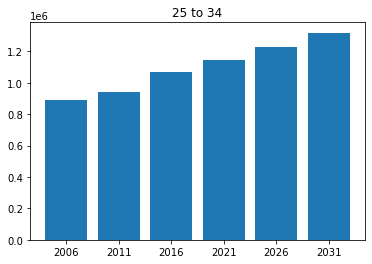

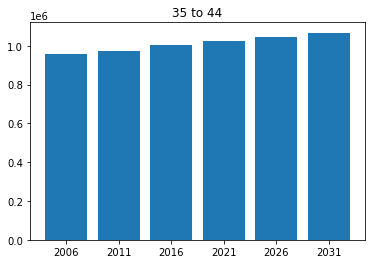

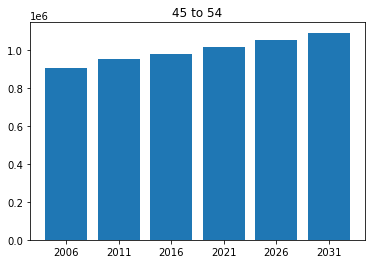

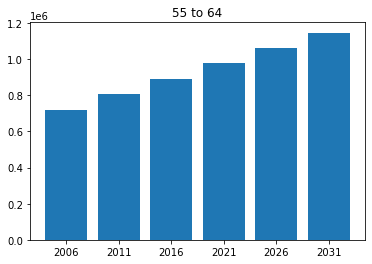

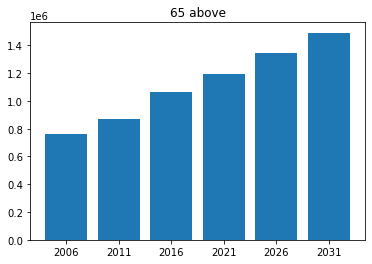

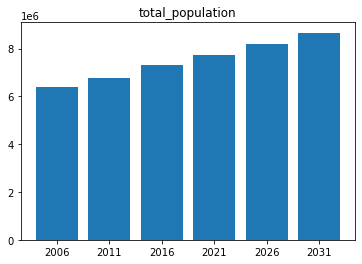

In [12]:
age_df_transposed, cols = reset_df(age_df = age_df)
ransac_model = RANSACRegressor()
ransac_prediction_df = create_dataframe(ransac_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_ransac_results_age = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), ransac_prediction_df])

In [13]:
df_with_ransac_results_age = df_with_ransac_results_age.add_suffix('_ransac_model')
df_with_ransac_results_age

,below 18 years_ransac_model,18 to 25_ransac_model,25 to 34_ransac_model,35 to 44_ransac_model,45 to 54_ransac_model,55 to 64_ransac_model,65 above_ransac_model,total_population_ransac_model
2006,1653876.0,516768.0,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,765073.0,6408484.0
2011,1688546.0,537074.0,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,867459.0,6766973.0
2016,1742488.0,581935.0,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1061819.0,7324395.0
2021,1783582.0,610426.0,1.143175e+06,1.022493e+06,1.017905e+06,9.767513e+05,1194863.0,7749195.0
2026,1827888.0,643009.5,1.231416e+06,1.045012e+06,1.054728e+06,1.061862e+06,1343236.0,8207150.5
2031,1872194.0,675593.0,1.319656e+06,1.067531e+06,1.091551e+06,1.146972e+06,1491609.0,8665106.0


### SGD Regression

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


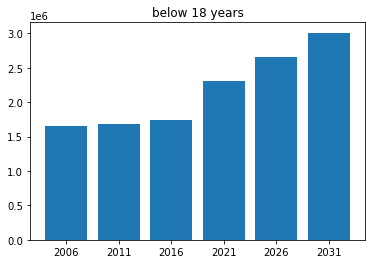

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


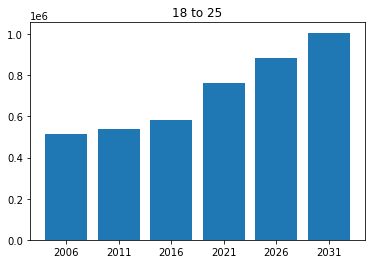

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


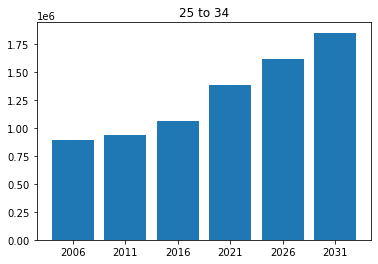

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


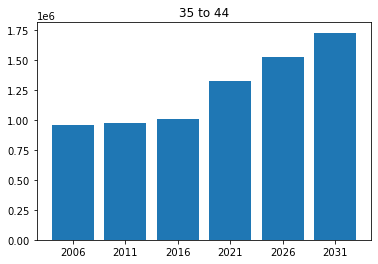

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


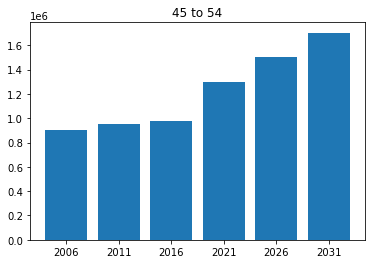

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


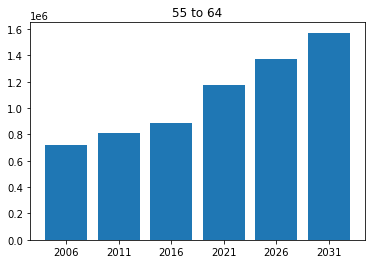

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


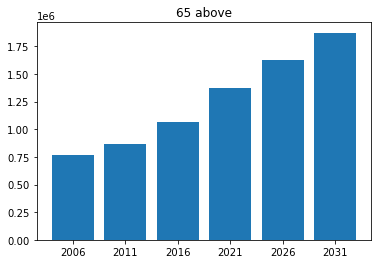

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


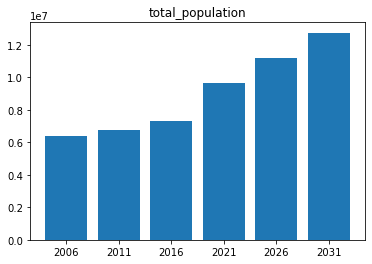

In [14]:
age_df_transposed, cols = reset_df(age_df = age_df)
sgd_model = SGDRegressor()
sgd_prediction_df = create_dataframe(sgd_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_sgd_results_age = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), sgd_prediction_df])

In [15]:
df_with_sgd_results_age = df_with_sgd_results_age.add_suffix('_SGD_model')
df_with_sgd_results_age

,below 18 years_SGD_model,18 to 25_SGD_model,25 to 34_SGD_model,35 to 44_SGD_model,45 to 54_SGD_model,55 to 64_SGD_model,65 above_SGD_model,total_population_SGD_model
2006,1.653876e+06,5.167680e+05,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,7.650730e+05,6.408484e+06
2011,1.688546e+06,5.370740e+05,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,8.674590e+05,6.766973e+06
2016,1.742488e+06,5.819350e+05,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1.061819e+06,7.324395e+06
2021,2.310056e+06,7.638991e+05,1.390792e+06,1.326656e+06,1.301096e+06,1.173492e+06,1.371480e+06,9.632348e+06
2026,2.659571e+06,8.856382e+05,1.622856e+06,1.525795e+06,1.502112e+06,1.372970e+06,1.622416e+06,1.118433e+07
2031,3.009086e+06,1.007377e+06,1.854920e+06,1.724934e+06,1.703128e+06,1.572447e+06,1.873352e+06,1.273631e+07


### Poission Regression

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


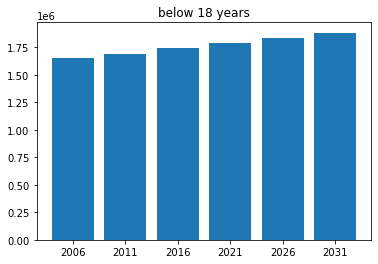

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


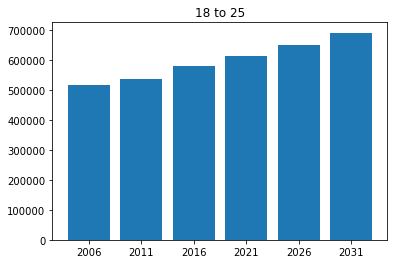

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


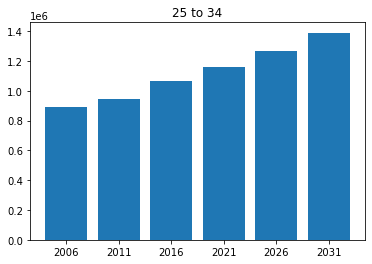

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


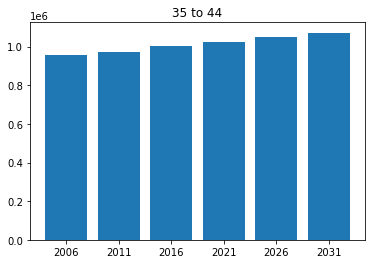

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


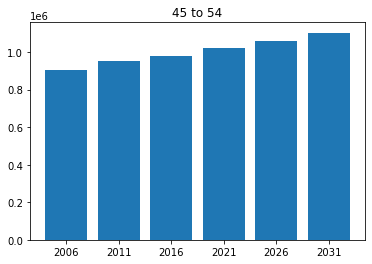

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


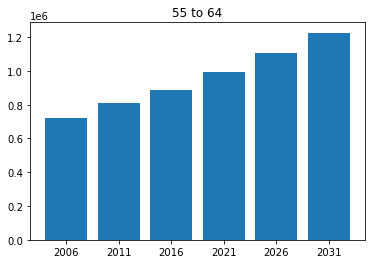

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


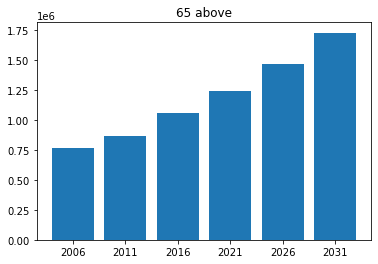

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


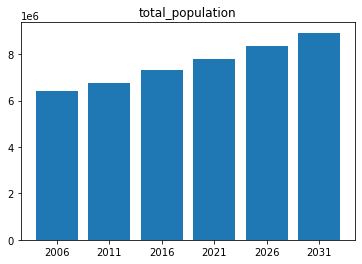

In [16]:
age_df_transposed, cols = reset_df(age_df = age_df)
poisson_model = PoissonRegressor()
poisson_prediction_df = create_dataframe(poisson_model, age_df_transposed, cols)
age_df_transposed.index = age_df_transposed.Dates
df_with_poisson_results_age = pd.concat([age_df_transposed.drop(labels = 'Dates', axis = 1), poisson_prediction_df])

In [17]:
df_with_poisson_results_age = df_with_poisson_results_age.add_suffix('_poission_prediction')
df_with_poisson_results_age

,below 18 years_poission_prediction,18 to 25_poission_prediction,25 to 34_poission_prediction,35 to 44_poission_prediction,45 to 54_poission_prediction,55 to 64_poission_prediction,65 above_poission_prediction,total_population_poission_prediction
2006,1.653876e+06,516768.000000,8.910470e+05,9.578440e+05,9.043370e+05,7.195390e+05,7.650730e+05,6.408484e+06
2011,1.688546e+06,537074.000000,9.415080e+05,9.716380e+05,9.504560e+05,8.102920e+05,8.674590e+05,6.766973e+06
2016,1.742488e+06,581935.000000,1.067528e+06,1.002882e+06,9.779830e+05,8.897600e+05,1.061819e+06,7.324395e+06
2021,1.785543e+06,613791.979180,1.157380e+06,1.023369e+06,1.020355e+06,9.927364e+05,1.240244e+06,7.802496e+06
2026,1.832837e+06,651612.038327,1.268159e+06,1.047222e+06,1.060942e+06,1.103440e+06,1.464143e+06,8.343746e+06
2031,1.881384e+06,691762.458446,1.389542e+06,1.071631e+06,1.103144e+06,1.226489e+06,1.728461e+06,8.922542e+06


In [18]:
def plot_comparison_results(column_number, df_with_linear_results, df_with_huber_results, df_with_sgd_results, df_with_ransac_results, df_with_poisson_results):
    a = pd.concat([df_with_linear_results.iloc[:,column_number],
                   df_with_huber_results.iloc[:, column_number],
                   df_with_sgd_results.iloc[:,column_number],
                   df_with_ransac_results.iloc[:,column_number],
                   df_with_poisson_results.iloc[:,column_number]],
                  axis = 1)
    a.iloc[3:,:].plot(kind = 'bar', figsize = (7,7))

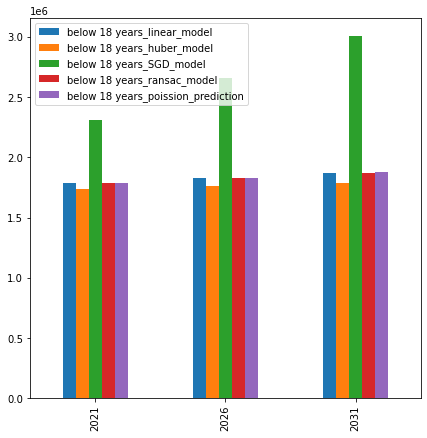

In [19]:
plot_comparison_results(0,
                        df_with_linear_results_age, 
                        df_with_huber_results_age, 
                        df_with_sgd_results_age, 
                        df_with_ransac_results_age, 
                        df_with_poisson_results_age)

# Prediction based on AGE

### Pre-processing steps
* Gender category is 'Male' and 'Female'

In [20]:
# since total population of male and female is required for year 06, 11, 16, we will only take the last file
age_file_df_5 = pd.read_csv(filepath_or_buffer = os.path.join(direcotry_path, file_path_5))
column_names = list(age_file_df_5.columns)
required_column_names = [names for names in column_names
                         if ('Tot' in names) & ('P' not in names)]
age_file_df_5_transpose = age_file_df_5[required_column_names].T

# extract the year from the index values
df_index = list(age_file_df_5_transpose.index)
age_file_df_5_transpose['year'] = [words[-4:-2] for words in df_index]

# selection of columns with either male or female, combination of both are not selected
male_series = [male for male in age_file_df_5_transpose.index
               if 'M' in male]
female_series = [male for male in age_file_df_5_transpose.index
                 if 'F' in male]
male_series_df = age_file_df_5_transpose.loc[male_series,:]
female_series_df = age_file_df_5_transpose.loc[female_series,:]

# after selecting male or female, changing the column name to male population and female population
male_series_df = male_series_df.rename(columns = {0: 'Male_Population',
                                                  'year': 'Year'})
female_series_df = female_series_df.rename(columns ={0: 'Female_Population'})

# changing the index for regression models
male_series_df.index = [1,2,3]
female_series_df.index = [1,2,3]

# combining the male and female dataframes to get a single dataframe
combined_gender_df = pd.concat([male_series_df, female_series_df], axis = 1)
combined_gender_df.drop(labels = 'Year', axis = 1, inplace = True)
combined_gender_df

,Male_Population,Female_Population,year
1,3228451,3320726,06
2,3408880,3508782,11
3,3686014,3794217,16


In [21]:
def reset_index_gender_df(dataframe):
    '''
    This function will reset the index as per regression function requirements
    '''
    dataframe.index = ['1', '2', '3']
    cols = list(dataframe.columns)
    return dataframe, cols

### Regression Models

#### Linear Regression

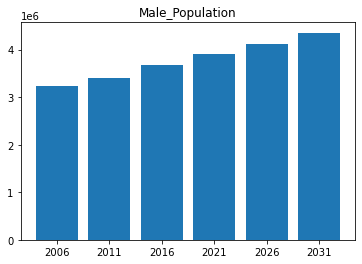

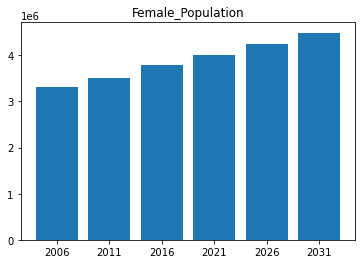

In [22]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = LinearRegression()
linear_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_linear_results_gender = pd.concat([combined_gender_df, linear_prediction_df])
df_with_linear_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [23]:
df_with_linear_results_gender = df_with_linear_results_gender.add_suffix('_linear_model')
df_with_linear_results_gender

,Male_Population_linear_model,Female_Population_linear_model
2006,3228451.0,3.320726e+06
2011,3408880.0,3.508782e+06
2016,3686014.0,3.794217e+06
2021,3898678.0,4.014733e+06
2026,4127459.5,4.251478e+06
2031,4356241.0,4.488224e+06


#### Huber Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


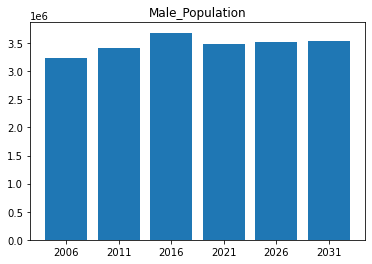

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


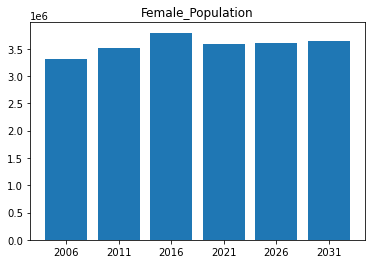

In [24]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = HuberRegressor()
huber_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_huber_results_gender = pd.concat([combined_gender_df, huber_prediction_df])
df_with_huber_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [25]:
df_with_huber_results_gender = df_with_huber_results_gender.add_suffix('_huber_model')
df_with_huber_results_gender

,Male_Population_huber_model,Female_Population_huber_model
2006,3.228451e+06,3.320726e+06
2011,3.408880e+06,3.508782e+06
2016,3.686014e+06,3.794217e+06
2021,3.489655e+06,3.589808e+06
2026,3.513924e+06,3.614091e+06
2031,3.538194e+06,3.638375e+06


#### RANSAC Regression Model

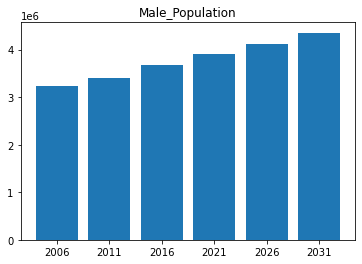

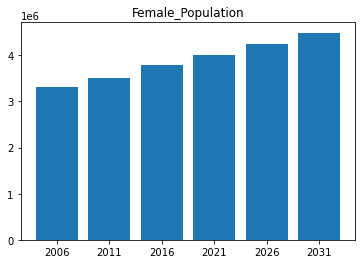

In [26]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = RANSACRegressor()
ransac_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_ransac_results_gender = pd.concat([combined_gender_df, ransac_prediction_df])
df_with_ransac_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [27]:
df_with_ransac_results_gender = df_with_ransac_results_gender.add_suffix('_ransac_model')
df_with_ransac_results_gender

,Male_Population_ransac_model,Female_Population_ransac_model
2006,3228451.0,3.320726e+06
2011,3408880.0,3.508782e+06
2016,3686014.0,3.794217e+06
2021,3898678.0,4.014733e+06
2026,4127459.5,4.251478e+06
2031,4356241.0,4.488224e+06


#### SGD Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


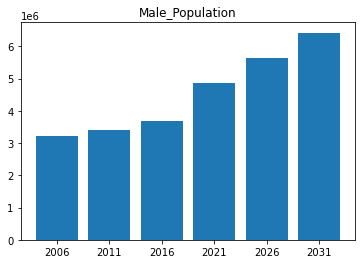

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


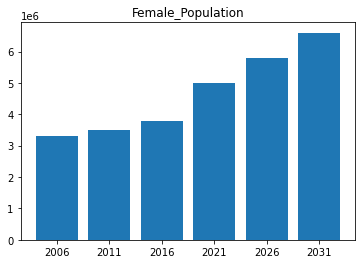

In [28]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = SGDRegressor()
sgd_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_sgd_results_gender = pd.concat([combined_gender_df, sgd_prediction_df])
df_with_sgd_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [29]:
df_with_sgd_results_gender = df_with_sgd_results_gender.add_suffix('_sgd_model')
df_with_sgd_results_gender

,Male_Population_sgd_model,Female_Population_sgd_model
2006,3.228451e+06,3.320726e+06
2011,3.408880e+06,3.508782e+06
2016,3.686014e+06,3.794217e+06
2021,4.854534e+06,4.991104e+06
2026,5.637472e+06,5.795081e+06
2031,6.420410e+06,6.599057e+06


#### Poission Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


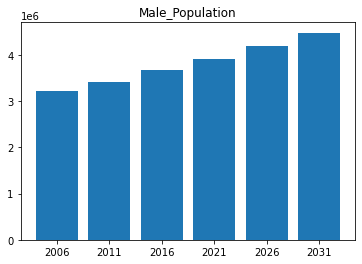

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


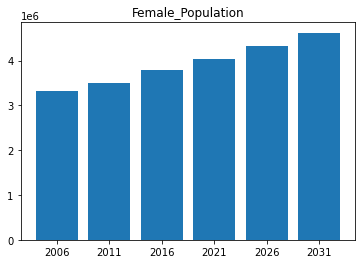

In [30]:
combined_gender_df, cols = reset_index_gender_df(combined_gender_df)
model = PoissonRegressor()
poisson_prediction_df = create_dataframe(model, combined_gender_df, cols)
combined_gender_df.index = ['2006', '2011', '2016']
df_with_poisson_results_gender = pd.concat([combined_gender_df, poisson_prediction_df])
df_with_poisson_results_gender.drop(labels = 'year', axis = 1, inplace = True)

In [31]:
df_with_poisson_results_gender = df_with_poisson_results_gender.add_suffix('_poisson_model')
df_with_poisson_results_gender

,Male_Population_poisson_model,Female_Population_poisson_model
2006,3.228451e+06,3.320726e+06
2011,3.408880e+06,3.508782e+06
2016,3.686014e+06,3.794217e+06
2021,3.925085e+06,4.042217e+06
2026,4.195119e+06,4.321908e+06
2031,4.483730e+06,4.620951e+06


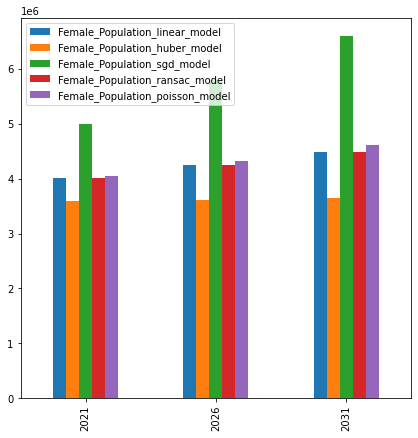

In [32]:
plot_comparison_results(1,
                        df_with_linear_results_gender, 
                        df_with_huber_results_gender, 
                        df_with_sgd_results_gender, 
                        df_with_ransac_results_gender, 
                        df_with_poisson_results_gender)

# Income Category

### Pre-Processing
* Income categories are:
    * 0-399
    * 400-799
    * 800-1249
    * 1250-1999
    * 2000-4000
    * 4000+
    
* From previous categories like [0 - 399] and [400 - 799] weekly income categories are reducing, hence a few regresion models are predicting negative values. In these cases, the negative values are replaced with zero.

In [33]:
# income category has two file parts
file_path_1 = '2016Census_T22A_NSW_STE.csv'
file_path_2 = '2016Census_T22B_NSW_STE.csv'
income_file_df_1 = pd.read_csv(filepath_or_buffer = os.path.join(direcotry_path, file_path_1))
income_file_df_2 = pd.read_csv(filepath_or_buffer = os.path.join(direcotry_path, file_path_2))

# combining both the dataframes
income_file_df_combined = pd.concat([income_file_df_1, income_file_df_2], axis = 1)
income_columns = list(income_file_df_combined.columns)

# extracting the column names which have total, since this dataframe also has income with number of children
# category, negative values not considered
required_column_names = [names for names in income_columns
 if ('T' in names) & ('STE' not in names) & ('Tot' not in names) & ('N' not in names)
 & ('Par' not in names) & ('All' not in names)]

# dataframe with required columns only
income_file_df_combined_1 = income_file_df_combined[required_column_names]
column_names_1 = list(income_file_df_combined_1.columns)

# cateogry column from 1 to 399 income bracket
first_category = [names for  names in column_names_1
                  if ('1_149' in names) | ('150_299' in names) | ('300_399' in names)]

# category columns from 400 to 799 income bracket
second_category = [names for  names in column_names_1
                  if ('400_499' in names) | ('500_649' in names) | ('650_799' in names)]

# category columns from 800 to 1500 income bracket
third_category = [names for  names in column_names_1
                  if ('800_999' in names) | ('1000_1499' in names)]

# category columns from 1500 to 1999 income bracket
fourth_category = [names for  names in column_names_1
                  if ('1500_1999' in names)]

# category columns from 2000 to 4000 income bracket
fifth_category = [names for  names in column_names_1
                  if ('2000_2499' in names) | ('2500_2999' in names) | ('3000_3999' in names)]

# category columns from 4000 and above income bracket
sixth_category = [names for  names in column_names_1
                  if ('4000m_CF' in names)]


def return_income_categories(dataframe,category):
    '''
    
    dataframe: the pandas dataframe, here it is income_file_df_combined_1,
    category = income category.
    
    This function will return the series of sum for particular category for a particular year
    '''
    num = int((len(dataframe[category].columns))/3)
    zero_399_06 = np.sum(((dataframe[category]).T).iloc[:num, 0])
    zero_399_11 = np.sum(((dataframe[category]).T).iloc[num:num+num, 0])
    zero_399_16 = np.sum(((dataframe[category]).T).iloc[num+num:, 0])
    return zero_399_06, zero_399_11, zero_399_16


# adding and getting required values for each category and year variables
first_category_06, first_category_11, first_category_16 = return_income_categories(dataframe = income_file_df_combined_1,
                                                                                   category = first_category)

second_category_06, second_category_11, second_category_16 = return_income_categories(dataframe = income_file_df_combined_1,
                                                                                   category = second_category)

third_category_06, third_category_11, third_category_16 = return_income_categories(dataframe = income_file_df_combined_1,
                                                                                   category = third_category)

fourth_category_06, fourth_category_11, fourth_category_16 = return_income_categories(dataframe = income_file_df_combined_1,
                                                                                   category = fourth_category)

fifth_category_06, fifth_category_11, fifth_category_16 = return_income_categories(dataframe = income_file_df_combined_1,
                                                                                   category = fifth_category)

sixth_category_06, sixth_category_11, sixth_category_16 = return_income_categories(dataframe = income_file_df_combined_1,
                                                                                   category = sixth_category)

# sending the above data to a dataframe
income_df = pd.DataFrame()
income_df['2006_data'] = pd.Series([first_category_06, second_category_06, third_category_06, fourth_category_06, fifth_category_06, sixth_category_06])
income_df['2011_data'] = pd.Series([first_category_11, second_category_11, third_category_11, fourth_category_11, fifth_category_11, sixth_category_11])
income_df['2016_data'] = pd.Series([first_category_16, second_category_16, third_category_16, fourth_category_16, fifth_category_16, sixth_category_16])

income_df.index = ['1_399', '400_799', '800_1499', '1499_1999', '2000_3999', '4000_above']

income_df

,2006_data,2011_data,2016_data
1_399,14595,11627,6582
400_799,82115,54559,37764
800_1499,217760,167780,138662
1499_1999,120383,119462,116529
2000_3999,209003,302591,338910
4000_above,24993,58342,134000


In [34]:
income_df_transposed = income_df.T
income_df_transposed.index = ['2006', '2011', '2016']
# age_df_transposed.index = pd.DatetimeIndex(data = age_df_transposed.index)
income_df_transposed['Dates'] = age_df_transposed.index
income_df_transposed.index = ['1', '2','3']
cols = list(income_df_transposed.columns)
income_df_transposed

,1_399,400_799,800_1499,1499_1999,2000_3999,4000_above,Dates
1,14595,82115,217760,120383,209003,24993,2006
2,11627,54559,167780,119462,302591,58342,2011
3,6582,37764,138662,116529,338910,134000,2016


### Regression Models

#### Linear Regression
* If the model is predicting negative values, they are shown as zero, hence some predictions have no bars

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


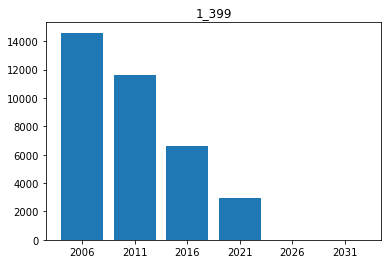

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


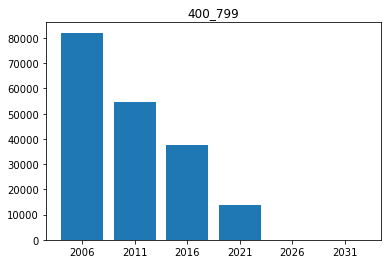

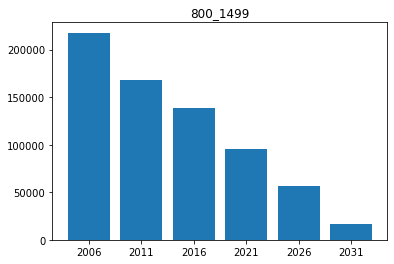

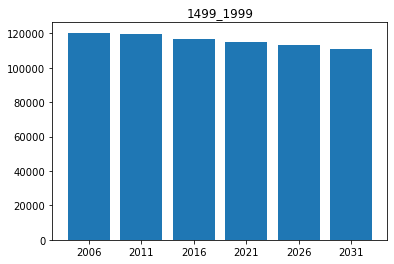

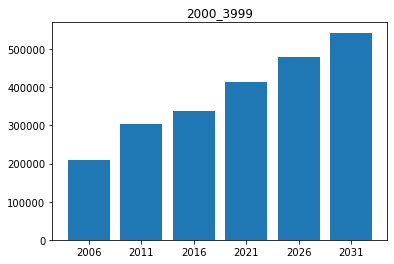

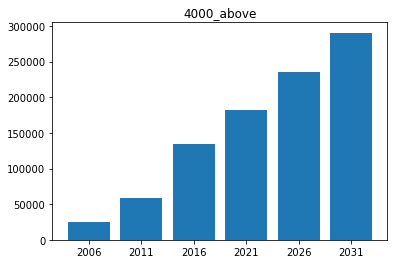

In [35]:
# reset the dataframe with index and column names as per requirement
income_df_transposed, cols = reset_index_gender_df(income_df_transposed)

# regression model object
linear_model_income = LinearRegression()

# using the function to create a dataframe with regression results
linear_prediction_df = create_dataframe(linear_model_income, income_df_transposed, cols)

# adding the index of years for dataframe
income_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_linear_results_income = pd.concat([income_df_transposed, linear_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_linear_results_income.drop(labels = 'Dates', axis = 1, inplace = True)

In [36]:
# adding suffix of model name for future identification
df_with_linear_results_income = df_with_linear_results_income.add_suffix('_linear_model')
df_with_linear_results_income

,1_399_linear_model,400_799_linear_model,800_1499_linear_model,1499_1999_linear_model,2000_3999_linear_model,4000_above_linear_model
2006,14595.000000,82115.0,217760.0,120383.000000,209003.000000,24993.0
2011,11627.000000,54559.0,167780.0,119462.000000,302591.000000,58342.0
2016,6582.000000,37764.0,138662.0,116529.000000,338910.000000,134000.0
2021,2921.666667,13795.0,95636.0,114937.333333,413408.333333,181452.0
2026,0.000000,0.0,56087.0,113010.333333,478361.833333,235955.5
2031,0.000000,0.0,16538.0,111083.333333,543315.333333,290459.0


#### Huber Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


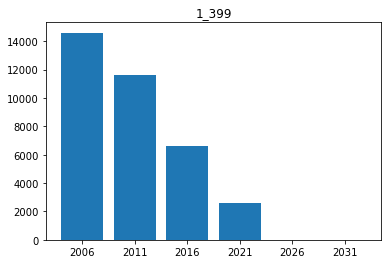

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


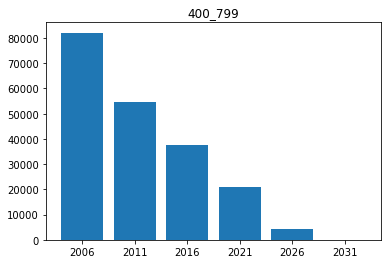

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


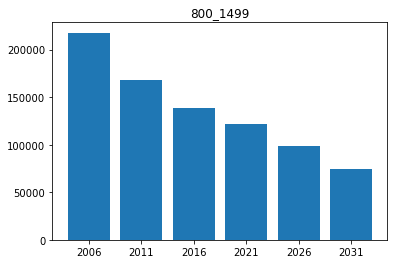

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_huber.py:86: RuntimeWarning: invalid value encountered in double_scalars
  squared_loss = weighted_loss / sigma
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_huber.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_huber.py:96: RuntimeWarning: invalid value encountered in multiply
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-pack

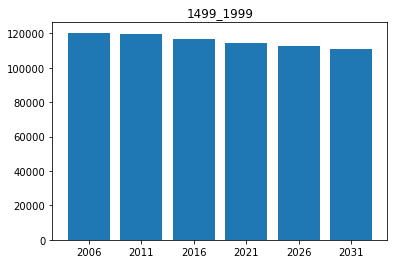

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


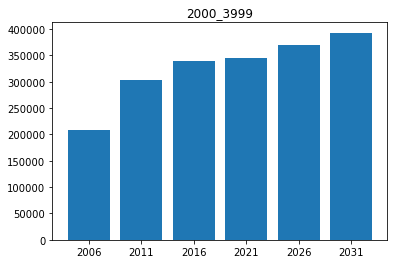

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


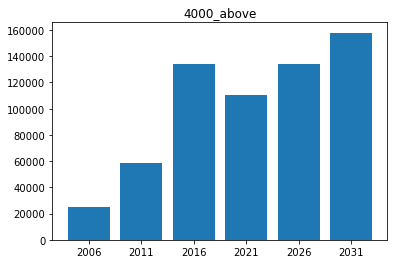

In [37]:
# reset the dataframe with index and column names as per requirement
income_df_transposed, cols = reset_index_gender_df(income_df_transposed)

# regression model object
huber_model_income = HuberRegressor()

# using the function to create a dataframe with regression results
huber_prediction_df = create_dataframe(huber_model_income, income_df_transposed, cols)

# adding the index of years for dataframe
income_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_huber_results_income = pd.concat([income_df_transposed, huber_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_huber_results_income.drop(labels = 'Dates', axis = 1, inplace = True)

In [38]:
# adding suffix of model name for future identification
df_with_huber_results_income = df_with_huber_results_income.add_suffix('_huber_model')
df_with_huber_results_income

,1_399_huber_model,400_799_huber_model,800_1499_huber_model,1499_1999_huber_model,2000_3999_huber_model,4000_above_huber_model
2006,14595.000000,82115.000000,217760.000000,120383.000000,209003.000000,24993.000000
2011,11627.000000,54559.000000,167780.000000,119462.000000,302591.000000,58342.000000
2016,6582.000000,37764.000000,138662.000000,116529.000000,338910.000000,134000.000000
2021,2609.507556,20969.123836,122201.023553,114603.815862,345109.362807,110155.582735
2026,0.000000,4172.537867,98302.401729,112672.483764,369007.978434,134054.098880
2031,0.000000,0.000000,74403.779905,110741.151666,392906.594062,157952.615026


#### RANSAC Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


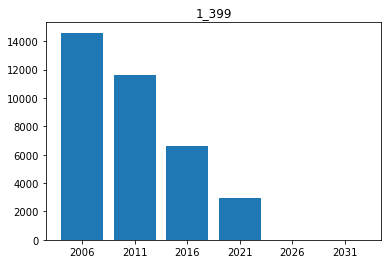

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


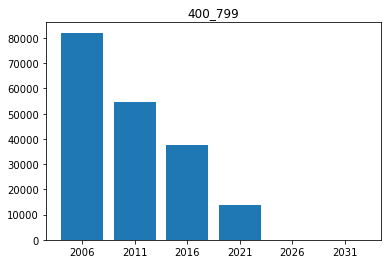

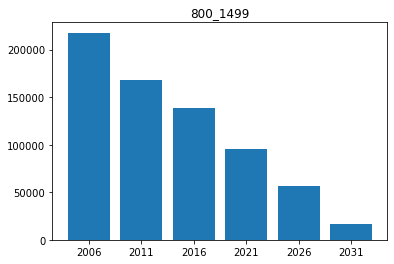

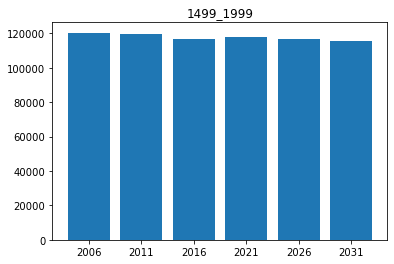

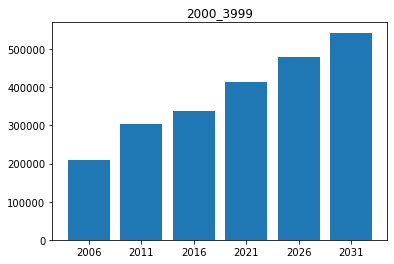

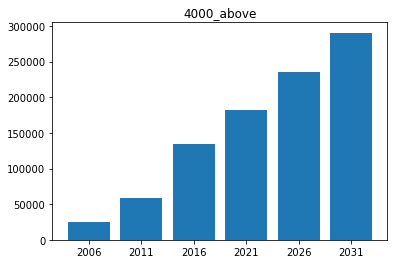

In [39]:
# reset the dataframe with index and column names as per requirement
income_df_transposed, cols = reset_index_gender_df(income_df_transposed)

# regression model object
ransac_model_income = RANSACRegressor()

# using the function to create a dataframe with regression results
ransac_prediction_df = create_dataframe(ransac_model_income, income_df_transposed, cols)

# adding the index of years for dataframe
income_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_ransac_results_income = pd.concat([income_df_transposed, ransac_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_ransac_results_income.drop(labels = 'Dates', axis = 1, inplace = True)

In [40]:
# adding suffix of model name for future identification
df_with_ransac_results_income = df_with_ransac_results_income.add_suffix('_ransac_model')
df_with_ransac_results_income

,1_399_ransac_model,400_799_ransac_model,800_1499_ransac_model,1499_1999_ransac_model,2000_3999_ransac_model,4000_above_ransac_model
2006,14595.000000,82115.0,217760.0,120383.0,209003.000000,24993.0
2011,11627.000000,54559.0,167780.0,119462.0,302591.000000,58342.0
2016,6582.000000,37764.0,138662.0,116529.0,338910.000000,134000.0
2021,2921.666667,13795.0,95636.0,117620.0,413408.333333,181452.0
2026,0.000000,0.0,56087.0,116699.0,478361.833333,235955.5
2031,0.000000,0.0,16538.0,115778.0,543315.333333,290459.0


#### SGD Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


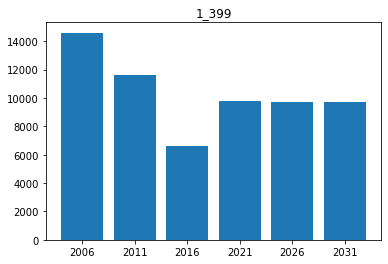

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


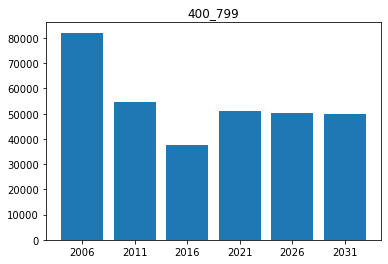

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


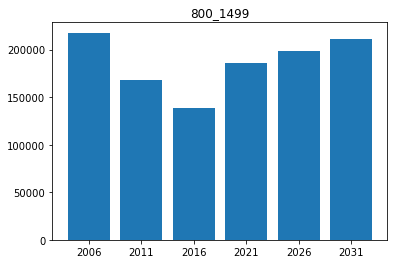

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


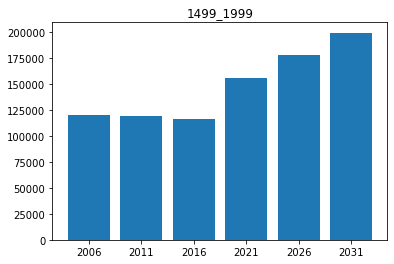

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


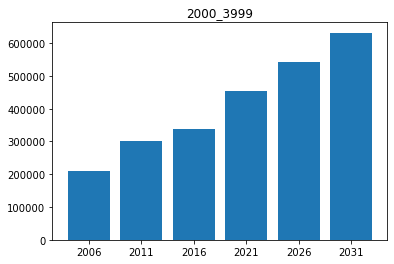

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


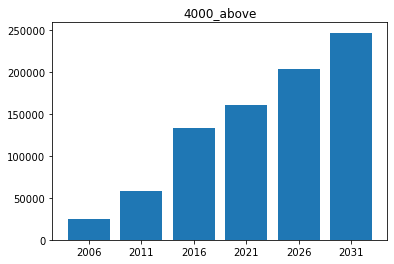

In [41]:
# reset the dataframe with index and column names as per requirement
income_df_transposed, cols = reset_index_gender_df(income_df_transposed)

# regression model object
sgd_model_income = SGDRegressor()

# using the function to create a dataframe with regression results
sgd_prediction_df = create_dataframe(sgd_model_income, income_df_transposed, cols)

# adding the index of years for dataframe
income_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_sgd_results_income = pd.concat([income_df_transposed, sgd_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_sgd_results_income.drop(labels = 'Dates', axis = 1, inplace = True)

In [42]:
# adding suffix of model name for future identification
df_with_sgd_results_income = df_with_sgd_results_income.add_suffix('_sgd_model')
df_with_sgd_results_income

,1_399_sgd_model,400_799_sgd_model,800_1499_sgd_model,1499_1999_sgd_model,2000_3999_sgd_model,4000_above_sgd_model
2006,14595.000000,82115.000000,217760.000000,120383.000000,209003.000000,24993.000000
2011,11627.000000,54559.000000,167780.000000,119462.000000,302591.000000,58342.000000
2016,6582.000000,37764.000000,138662.000000,116529.000000,338910.000000,134000.000000
2021,9755.029980,51016.743452,185578.824987,155885.657929,454378.733511,161430.610099
2026,9716.158746,50417.513889,198168.614722,177699.518214,543174.385708,204313.447713
2031,9677.287513,49818.284327,210758.404457,199513.378499,631970.037906,247196.285327


#### Poisson Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


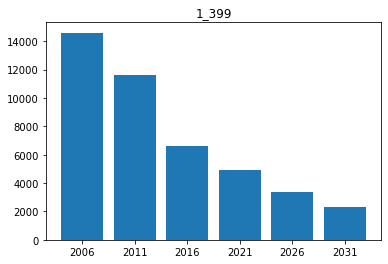

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


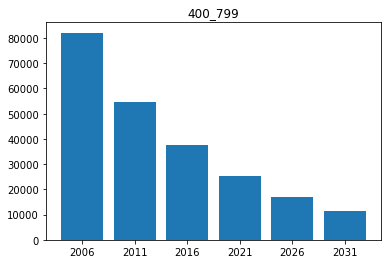

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


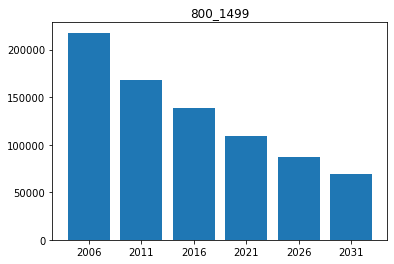

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


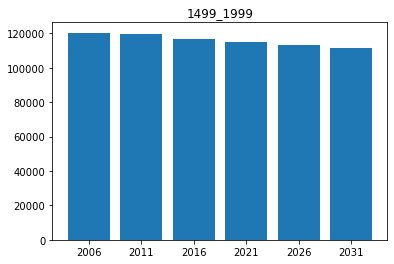

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


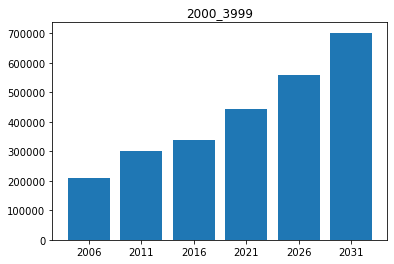

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


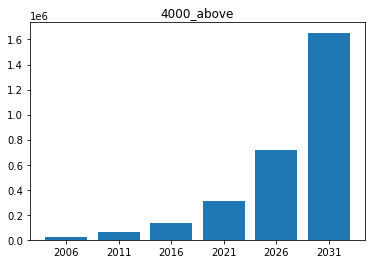

In [43]:
# reset the dataframe with index and column names as per requirement
income_df_transposed, cols = reset_index_gender_df(income_df_transposed)

# regression model object
possion_model_income = PoissonRegressor()

# using the function to create a dataframe with regression results
poisson_prediction_df = create_dataframe(possion_model_income, income_df_transposed, cols)

# adding the index of years for dataframe
income_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_poisson_results_income = pd.concat([income_df_transposed, poisson_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_poisson_results_income.drop(labels = 'Dates', axis = 1, inplace = True)

In [44]:
# adding suffix of model name for future identification
df_with_poisson_results_income = df_with_poisson_results_income.add_suffix('_poisson_model')
df_with_poisson_results_income

,1_399_poisson_model,400_799_poisson_model,800_1499_poisson_model,1499_1999_poisson_model,2000_3999_poisson_model,4000_above_poisson_model
2006,14595.000000,82115.000000,217760.000000,120383.000000,209003.000000,2.499300e+04
2011,11627.000000,54559.000000,167780.000000,119462.000000,302591.000000,5.834200e+04
2016,6582.000000,37764.000000,138662.000000,116529.000000,338910.000000,1.340000e+05
2021,4932.699786,25295.035238,108784.815601,114988.977578,442206.402032,3.098854e+05
2026,3390.622037,17108.878663,86580.481446,113138.648883,557198.781242,7.158965e+05
2031,2330.633992,11571.983448,68908.328116,111318.094487,702094.045656,1.653862e+06


#### Model Results comparison

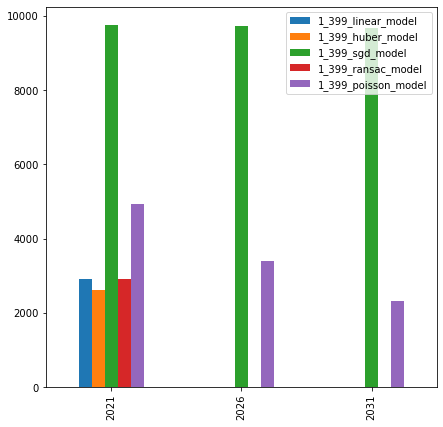

In [45]:
plot_comparison_results(0,
                        df_with_linear_results_income, 
                        df_with_huber_results_income, 
                        df_with_sgd_results_income, 
                        df_with_ransac_results_income, 
                        df_with_poisson_results_income)

# Marriage Category

* Marriage category is devided into 3 parts namely;
    * Married in a registered marriage
    * De facto
    * Not Married

In [46]:
# Main directory path is same, but for marriage category we will use 3 parts of file_05
file_path_1 = '2016Census_T05A_NSW_STE.csv'
file_path_2 = '2016Census_T05B_NSW_STE.csv'
file_path_3 = '2016Census_T05C_NSW_STE.csv'
married_file_df_1 = pd.read_csv(filepath_or_buffer = os.path.join(direcotry_path, file_path_1))
married_file_df_2 = pd.read_csv(filepath_or_buffer = os.path.join(direcotry_path, file_path_2))
married_file_df_3 = pd.read_csv(filepath_or_buffer = os.path.join(direcotry_path, file_path_3))

# combining all the dataframes
married_file_df_combined = pd.concat([married_file_df_1, married_file_df_2, married_file_df_3], axis = 1)
married_columns = list(married_file_df_combined.columns)

# extracting the column names which have total, since this dataframe also has income with number of children
required_column_names = [names for names in married_columns
                         if ('Tot_N' in names) | ('T_Mar' in names)]

married_file_df_required_columns = married_file_df_combined[required_column_names]

column_names_1 = list(married_file_df_required_columns.columns)

# cateogry column from married registered
first_category = [names for  names in column_names_1
                  if ('T_Marr' in names)]

# category columns from married de_factor
second_category = [names for  names in column_names_1
                  if ('T_Mar_de' in names)]

# category columns from not married
third_category = [names for  names in column_names_1
                  if ('Tot_N_mar' in names)]

# adding and getting required values for each category and year variables
first_category_06, first_category_11, first_category_16 = return_income_categories(dataframe = married_file_df_required_columns,
                                                                                   category = first_category)


second_category_06, second_category_11, second_category_16 = return_income_categories(dataframe = married_file_df_required_columns,
                                                                                   category = second_category)

third_category_06, third_category_11, third_category_16 = return_income_categories(dataframe = married_file_df_required_columns,
                                                                                   category = third_category)

# sending the above data to a dataframe
maritial_df = pd.DataFrame()
maritial_df['2006_data'] = pd.Series([first_category_06, second_category_06, third_category_06])
maritial_df['2011_data'] = pd.Series([first_category_11, second_category_11, third_category_11])
maritial_df['2016_data'] = pd.Series([first_category_16, second_category_16, third_category_16])

# creating category index
maritial_df.index = ['Married_registered', 'Married_de_facto', 'Not_married']

# creating a transpose and changing index for regression models
maritial_df_transposed = maritial_df.T
maritial_df_transposed.index = ['2006', '2011', '2016']
maritial_df_transposed['Dates'] = maritial_df_transposed.index
maritial_df_transposed.index = ['1', '2','3']
cols = list(maritial_df_transposed.columns)
maritial_df_transposed

,Married_registered,Married_de_facto,Not_married,Dates
1,2394433,364902,1932878,2006
2,2514379,418727,2096246,2011
3,2612630,506133,2290887,2016


### Regression Models

#### Linear Regression model

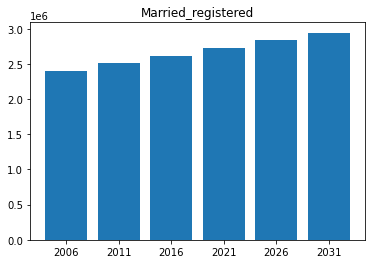

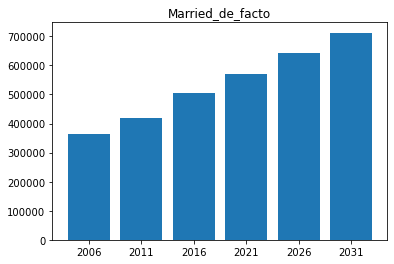

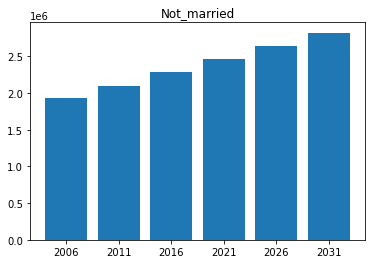

In [47]:
# reset the dataframe with index and column names as per requirement
maritial_df_transposed, cols = reset_index_gender_df(maritial_df_transposed)

# regression model object
linear_model_marriage = LinearRegression()

# using the function to create a dataframe with regression results
linear_prediction_df = create_dataframe(linear_model_marriage, maritial_df_transposed, cols)

# adding the index of years for dataframe
maritial_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_linear_results_marriage = pd.concat([maritial_df_transposed, linear_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_linear_results_marriage.drop(labels = 'Dates', axis = 1, inplace = True)

In [48]:
# adding suffix of model name for future identification
df_with_linear_results_marriage = df_with_linear_results_marriage.add_suffix('_linear_model')
df_with_linear_results_marriage

,Married_registered_linear_model,Married_de_facto_linear_model,Not_married_linear_model
2006,2.394433e+06,364902.000000,1.932878e+06
2011,2.514379e+06,418727.000000,2.096246e+06
2016,2.612630e+06,506133.000000,2.290887e+06
2021,2.725344e+06,571151.666667,2.464679e+06
2026,2.834443e+06,641767.166667,2.643684e+06
2031,2.943541e+06,712382.666667,2.822688e+06


#### Huber Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


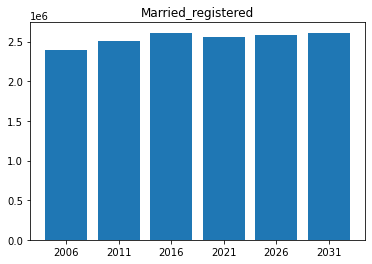

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


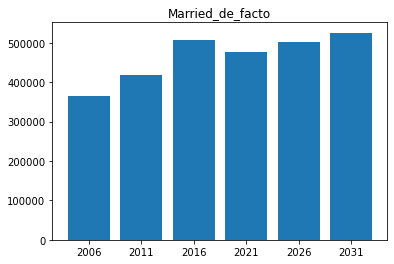

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


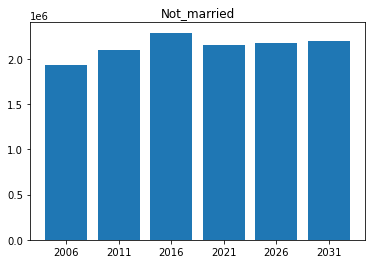

In [49]:
# reset the dataframe with index and column names as per requirement
maritial_df_transposed, cols = reset_index_gender_df(maritial_df_transposed)

# regression model object
huber_model_marriage = HuberRegressor()

# using the function to create a dataframe with regression results
huber_prediction_df = create_dataframe(huber_model_marriage, maritial_df_transposed, cols)

# adding the index of years for dataframe
maritial_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_huber_results_marriage = pd.concat([maritial_df_transposed, huber_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_huber_results_marriage.drop(labels = 'Dates', axis = 1, inplace = True)

In [50]:
# adding suffix of model name for future identification
df_with_huber_results_marriage = df_with_huber_results_marriage.add_suffix('_huber_model')
df_with_huber_results_marriage

,Married_registered_huber_model,Married_de_facto_huber_model,Not_married_huber_model
2006,2.394433e+06,364902.000000,1.932878e+06
2011,2.514379e+06,418727.000000,2.096246e+06
2016,2.612630e+06,506133.000000,2.290887e+06
2021,2.556004e+06,477885.066347,2.155581e+06
2026,2.580432e+06,501867.275577,2.180036e+06
2031,2.604860e+06,525849.484806,2.204491e+06


#### RANSAC Regression Model

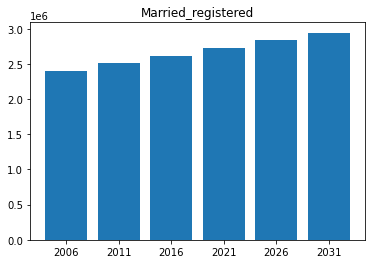

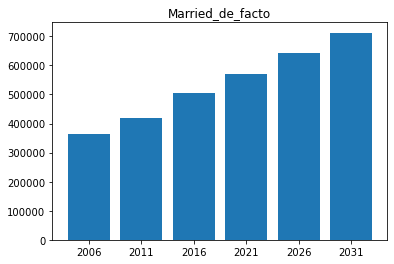

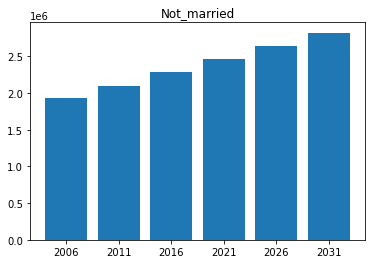

In [51]:
# reset the dataframe with index and column names as per requirement
maritial_df_transposed, cols = reset_index_gender_df(maritial_df_transposed)

# regression model object
ransac_model_marriage = RANSACRegressor()

# using the function to create a dataframe with regression results
ransac_prediction_df = create_dataframe(ransac_model_marriage, maritial_df_transposed, cols)

# adding the index of years for dataframe
maritial_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_ransac_results_marriage = pd.concat([maritial_df_transposed, ransac_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_ransac_results_marriage.drop(labels = 'Dates', axis = 1, inplace = True)

In [52]:
# adding suffix of model name for future identification
df_with_ransac_results_marriage = df_with_ransac_results_marriage.add_suffix('_ransac_model')
df_with_ransac_results_marriage

,Married_registered_ransac_model,Married_de_facto_ransac_model,Not_married_ransac_model
2006,2.394433e+06,364902.000000,1.932878e+06
2011,2.514379e+06,418727.000000,2.096246e+06
2016,2.612630e+06,506133.000000,2.290887e+06
2021,2.725344e+06,571151.666667,2.464679e+06
2026,2.834443e+06,641767.166667,2.643684e+06
2031,2.943541e+06,712382.666667,2.822688e+06


#### SGD Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


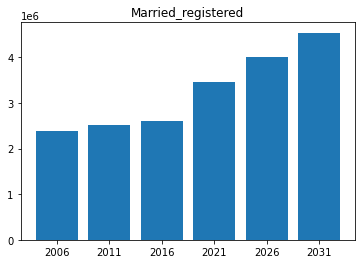

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


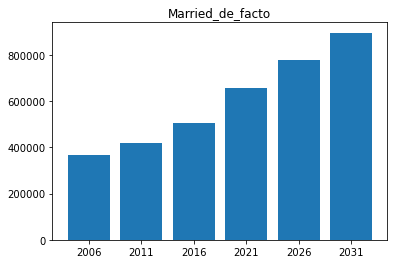

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


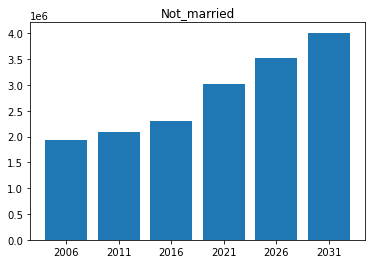

In [53]:
# reset the dataframe with index and column names as per requirement
maritial_df_transposed, cols = reset_index_gender_df(maritial_df_transposed)

# regression model object
sgd_model_marriage = SGDRegressor()

# using the function to create a dataframe with regression results
sgd_prediction_df = create_dataframe(sgd_model_marriage, maritial_df_transposed, cols)

# adding the index of years for dataframe
maritial_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_sgd_results_marriage = pd.concat([maritial_df_transposed, sgd_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_sgd_results_marriage.drop(labels = 'Dates', axis = 1, inplace = True)

In [54]:
# adding suffix of model name for future identification
df_with_sgd_results_marriage = df_with_sgd_results_marriage.add_suffix('_sgd_model')
df_with_sgd_results_marriage

,Married_registered_sgd_model,Married_de_facto_sgd_model,Not_married_sgd_model
2006,2.394433e+06,364902.000000,1.932878e+06
2011,2.514379e+06,418727.000000,2.096246e+06
2016,2.612630e+06,506133.000000,2.290887e+06
2021,3.463539e+06,656003.886658,3.013539e+06
2026,4.001557e+06,775900.326790,3.511569e+06
2031,4.539574e+06,895796.766922,4.009599e+06


#### Poission Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


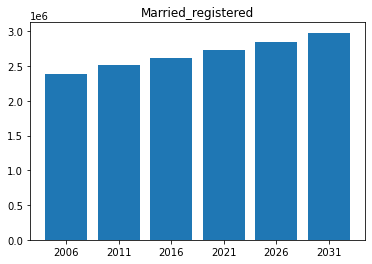

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


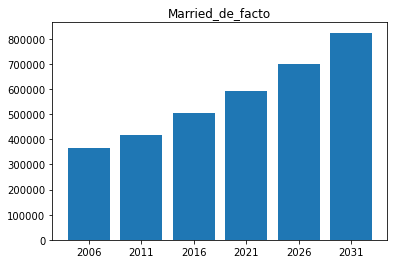

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


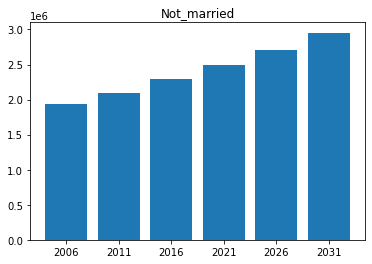

In [55]:
# reset the dataframe with index and column names as per requirement
maritial_df_transposed, cols = reset_index_gender_df(maritial_df_transposed)

# regression model object
poisson_model_marriage = PoissonRegressor()

# using the function to create a dataframe with regression results
poisson_prediction_df = create_dataframe(poisson_model_marriage, maritial_df_transposed, cols)

# adding the index of years for dataframe
maritial_df_transposed.index = ['2006', '2011', '2016']

# combining the original and prediction dataframe
df_with_poisson_results_marriage = pd.concat([maritial_df_transposed, poisson_prediction_df])

# removing the 'Dates' column, since the index column already has dates
df_with_poisson_results_marriage.drop(labels = 'Dates', axis = 1, inplace = True)

In [56]:
# adding suffix of model name for future identification
df_with_poisson_results_marriage = df_with_poisson_results_marriage.add_suffix('_poisson_model')
df_with_poisson_results_marriage

,Married_registered_poisson_model,Married_de_facto_poisson_model,Not_married_poisson_model
2006,2.394433e+06,364902.000000,1.932878e+06
2011,2.514379e+06,418727.000000,2.096246e+06
2016,2.612630e+06,506133.000000,2.290887e+06
2021,2.733469e+06,592611.337810,2.491396e+06
2026,2.855081e+06,698918.984600,2.712622e+06
2031,2.982104e+06,824296.998501,2.953493e+06


#### Model Results comparison

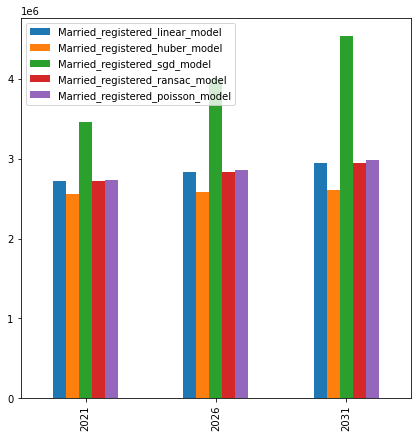

In [57]:
plot_comparison_results(0,
                        df_with_linear_results_marriage, 
                        df_with_huber_results_marriage, 
                        df_with_sgd_results_marriage, 
                        df_with_ransac_results_marriage, 
                        df_with_poisson_results_marriage)

# Postal Code Category

### Pre-processing

* SYDNEY Ppostal categories considered for prediction;
    * Sydney Areas            Postcode Ranges
    * Blue Mountains              2572 - 2786
    * Canterbury /Bankstown       2131 - 2372
    * Eastern Suburbs             2008 - 2036
    * Hawkesbury                  2081 - 2778
    * Hills                       2120 - 2768
    * Inner West                  2006 - 2372
    * Liverpool /Fairfield        2163 - 2566
    * Lower North Shore           2060 - 2111
    * Macarthur /Camden           2167 - 2574
    * Northern Beaches            2084 - 2108
    * Northern Suburbs            2110 - 2126
    * Parramatta                  2115 - 2199
    * St George                   2020 - 2223
    * Sutherland                  2173 - 2565
    * Sydney City                 2000 - 2011
    * Upper North Shore           2064 - 2580
    * Western Sydney              2145 - 2770


In [58]:
def get_dataframe_postal_code(directory_path, file_path, year):
    # load the dataframe
    postal_code_df_2016 = pd.read_csv(filepath_or_buffer = os.path.join(directory_path, file_path))
    
    # extract the postal code numbers
    postal_code_df_2016['Postal_code'] = pd.Series([words[3:] for words in postal_code_df_2016['POA_CODE_2016']])
    
    # extract total population with postal code
    postal_code_df_2016_1 = postal_code_df_2016.loc[:,['Tot_P_P', 'Postal_code']]
    
    # make 'Postal_code' column as index and drop this column
    postal_code_df_2016_1.index = postal_code_df_2016_1['Postal_code']
    postal_code_df_2016_1 = postal_code_df_2016_1.drop(labels = 'Postal_code', axis = 1)
    
    # get the list of postal code categories
    postal_code_df_2016_1_transpose = postal_code_df_2016_1.T
    transpose_columns = list(postal_code_df_2016_1_transpose.columns)
    
    def get_required_columns_post_code(start_list, end_list, column_list = transpose_columns ):
        '''
        Function to extract the postal codes as per requirement
        '''
        column_name = [ str(word) for word in list(range((start_list), (end_list)))]
        column_name = [numbers for numbers in column_name
                       if numbers in column_list]
        return column_name
    
    
    # get only the codes which are available in the columns list
    blue_mountains_column_names = get_required_columns_post_code(2572, 2787)
    canterbury_column_names = get_required_columns_post_code(2131, 2373)
    eastern_suburbs_column_names = get_required_columns_post_code(2008, 2037)
    hawkesbury_column_names = get_required_columns_post_code(2081, 2779)
    hills_column_names = get_required_columns_post_code(2120, 2769)
    inner_west_column_names = get_required_columns_post_code(2006, 2373)
    liverpool_column_names = get_required_columns_post_code(2163, 2567)
    lower_north_shore_column_names = get_required_columns_post_code(2060, 2112)
    macarthur_column_names = get_required_columns_post_code(2167, 2575)
    northern_beaches_column_names = get_required_columns_post_code(2084, 2109)
    northern_suburbs_column_names = get_required_columns_post_code(2110, 2127)
    parramatta_column_names = get_required_columns_post_code(2115, 2200)
    st_george_column_names = get_required_columns_post_code(2020, 2224)
    sunderland_column_names = get_required_columns_post_code(2173, 2566)
    sydney_city_column_names = get_required_columns_post_code(2000, 2012)
    upper_north_shore_column_names = get_required_columns_post_code(2064, 2581)
    western_sydney_column_names = get_required_columns_post_code(2145, 2771)
    
    # get the total population for required postal codes
    category_list = []
    category_names = [
                      blue_mountains_column_names,
                      canterbury_column_names,
                      eastern_suburbs_column_names,
                      hawkesbury_column_names,
                      hills_column_names,
                      inner_west_column_names,
                      liverpool_column_names,
                      lower_north_shore_column_names,
                      macarthur_column_names,
                      northern_beaches_column_names,
                      northern_suburbs_column_names,
                      parramatta_column_names,
                      st_george_column_names,
                      sunderland_column_names,
                      sydney_city_column_names,
                      upper_north_shore_column_names,
                      western_sydney_column_names]
    for i in category_names:
        category_list.append(np.sum((postal_code_df_2016_1.loc[i,:])))
        
    pattern = '[0-9]+'
    category_list_1 = []
    for i in category_list:
        category_list_1.append((re.findall(pattern, str(i)))[0])
    
    new_df = pd.DataFrame()
    new_df[year] = pd.Series(category_list_1)
    new_df.index = [
                      'blue_mountains',
                      'canterbury',
                      'eastern',
                      'hawkesbury',
                      'hills',
                      'inner_west',
                      'liverpool',
                      'lower_north_shore',
                      'macarthur',
                      'northern_beaches',
                      'northern_suburbs',
                      'parramatta',
                      'st_george',
                      'sunderland_',
                      'sydney_city',
                      'upper_north_shore',
                      'western_sydney']
    return new_df

In [59]:
directory_path_2016 = '2016_GCP_POA_for_NSW_short-header/2016 Census GCP Postal Areas for NSW/'
file_path_2016 = '2016Census_G01_NSW_POA.csv'
year = '2016'
df_2016_postal_code = get_dataframe_postal_code(directory_path_2016, file_path_2016, year)

In [60]:
directory_path_2011 = '2011_BCP_POA_for_NSW_short-header/2011 Census BCP Postal Areas for NSW/'
file_path_2011 = 'NSW/2011Census_B01_NSW_POA_short.csv'
year = '2011'
df_2011_postal_code = get_dataframe_postal_code(directory_path_2011, file_path_2011, year)

In [61]:
df_postal_code = pd.concat([df_2011_postal_code, df_2016_postal_code], axis = 1)
df_postal_code_transp = df_postal_code.T
df_postal_code_transp = df_postal_code_transp.astype('int')
df_postal_code_transp

,blue_mountains,canterbury,eastern,hawkesbury,hills,inner_west,liverpool,lower_north_shore,macarthur,northern_beaches,northern_suburbs,parramatta,st_george,sunderland_,sydney_city,upper_north_shore,western_sydney
2011,986163,2879909,389095,5686890,5119559,4329774,3372270,626164,3344381,289195,263988,1435088,2962287,3060706,92381,5091092,4833118
2016,1057604,3118380,438895,6137340,5522766,4716249,3596856,674163,3580687,306995,289404,1594641,3253597,3249927,110970,5502991,5196942


In [62]:
def model_results_postal(model, age_df_transposed, column):
    X = (age_df_transposed.index).values
    y = age_df_transposed.iloc[:,column].values
    X = X.reshape(-1,1)
    y = y.reshape(-1,1)
    column_names = age_df_transposed.columns
#     linear_model = LinearRegression()
    model.fit(X, y)
    X_test = ['4','5','6']
    X_test = np.array(X_test, dtype = 'object')
    X_test = X_test.reshape(-1,1)
    prediction = model.predict(X_test)
    prediction = [value  if (value>0) else 0 for value in prediction]
    plt.bar(['2011', '2016','2021', '2026', '2031'], np.append(age_df_transposed.iloc[:,column].values,prediction))
    plt.title(column_names[column])
    plt.show()
    return prediction

def create_dataframe_postal(model, dataframe, cols):
    prediction_results_partial = []
    prediction_results_nested = []
    prediction_dates = ['2021', '2026', '2031']
    for i in range(len(cols)):
        prediction_results_partial.append(model_results_postal(model,
                                                               age_df_transposed = dataframe,
                                                               column = i))
        prediction_results_nested.append(prediction_results_partial)
        prediction_results_partial = []
    new_df = pd.DataFrame()
    for i in range(len(prediction_results_nested)):
        new_df[i] = pd.Series(np.hstack(prediction_results_nested[i][0]))
    new_df.index = prediction_dates
    column_names = dataframe.columns
    new_df.columns = cols
    return new_df

def reset_index_postal_df(dataframe):
    dataframe.index = ['1', '2']
    cols = list(dataframe.columns)
    return dataframe, cols

### Regression Models

#### Linear Regression

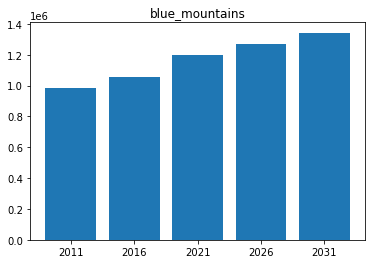

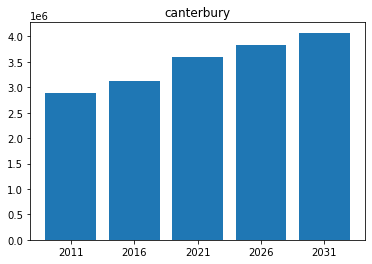

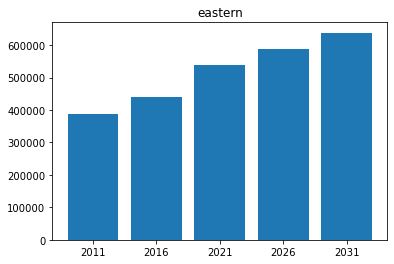

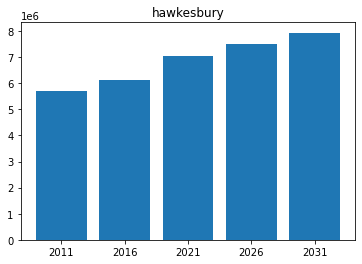

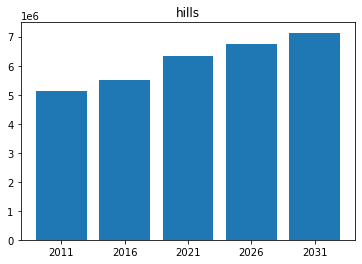

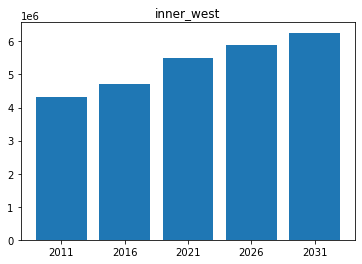

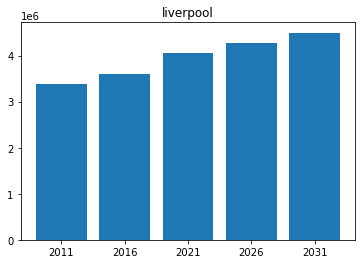

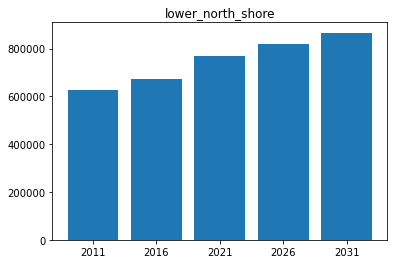

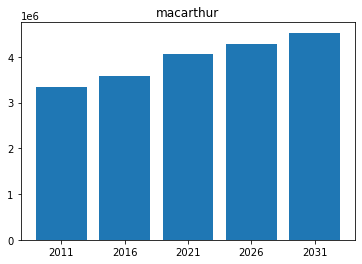

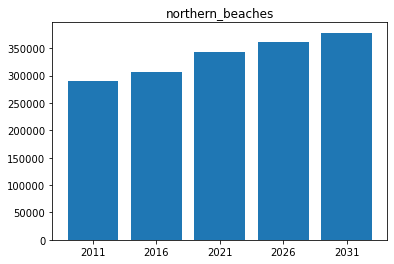

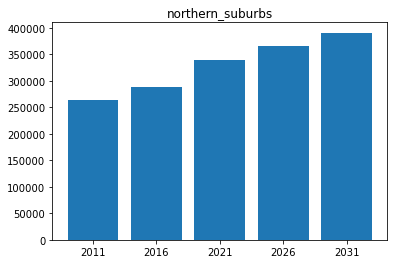

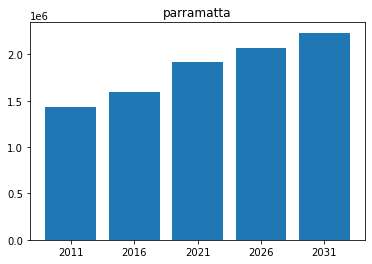

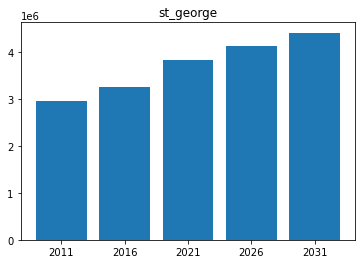

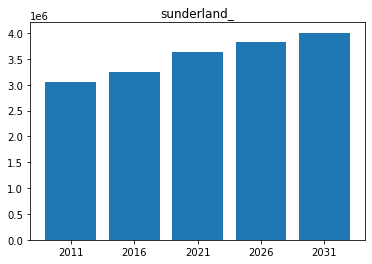

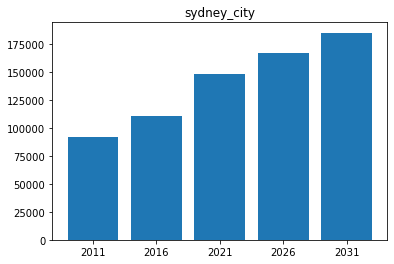

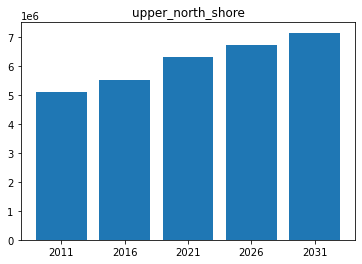

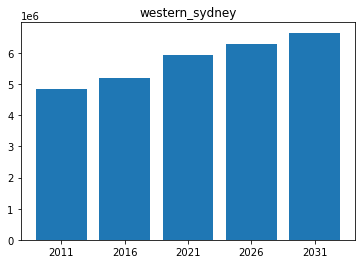

In [63]:
# reset the dataframe with index and column names as per requirement
postal_df_transposed, cols = reset_index_postal_df(df_postal_code_transp)

# regression model object
linear_model_postal = LinearRegression()

# using the function to create a dataframe with regression results
linear_prediction_df = create_dataframe_postal(linear_model_postal, postal_df_transposed, cols)

# adding the index of years for dataframe
postal_df_transposed.index = ['2011', '2016']

# combining the original and prediction dataframe
df_with_linear_results_postal = pd.concat([postal_df_transposed, linear_prediction_df])

In [64]:
# adding suffix of model name for future identification
df_with_linear_results_postal = df_with_linear_results_postal.add_suffix('_linear_model')
df_with_linear_results_postal

,blue_mountains_linear_model,canterbury_linear_model,eastern_linear_model,hawkesbury_linear_model,hills_linear_model,inner_west_linear_model,liverpool_linear_model,lower_north_shore_linear_model,macarthur_linear_model,northern_beaches_linear_model,northern_suburbs_linear_model,parramatta_linear_model,st_george_linear_model,sunderland__linear_model,sydney_city_linear_model,upper_north_shore_linear_model,western_sydney_linear_model
2011,986163.0,2879909.0,389095.0,5686890.0,5119559.0,4329774.0,3372270.0,626164.0,3344381.0,289195.0,263988.0,1435088.0,2962287.0,3060706.0,92381.0,5091092.0,4833118.0
2016,1057604.0,3118380.0,438895.0,6137340.0,5522766.0,4716249.0,3596856.0,674163.0,3580687.0,306995.0,289404.0,1594641.0,3253597.0,3249927.0,110970.0,5502991.0,5196942.0
2021,1200486.0,3595322.0,538495.0,7038240.0,6329180.0,5489199.0,4046028.0,770161.0,4053299.0,342595.0,340236.0,1913747.0,3836217.0,3628369.0,148148.0,6326789.0,5924590.0
2026,1271927.0,3833793.0,588295.0,7488690.0,6732387.0,5875674.0,4270614.0,818160.0,4289605.0,360395.0,365652.0,2073300.0,4127527.0,3817590.0,166737.0,6738688.0,6288414.0
2031,1343368.0,4072264.0,638095.0,7939140.0,7135594.0,6262149.0,4495200.0,866159.0,4525911.0,378195.0,391068.0,2232853.0,4418837.0,4006811.0,185326.0,7150587.0,6652238.0


#### RANSAC Regression Model

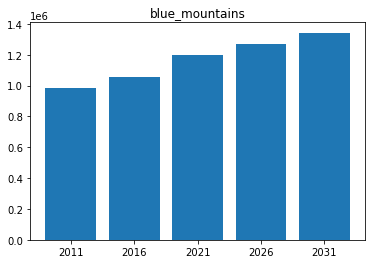

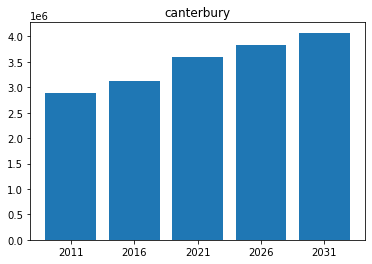

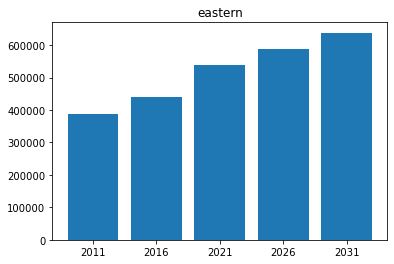

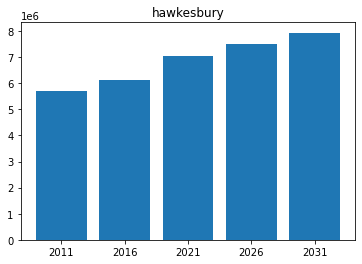

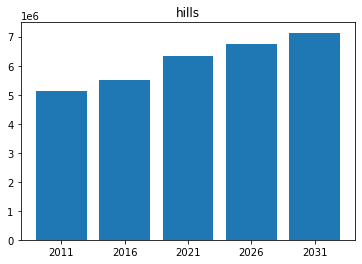

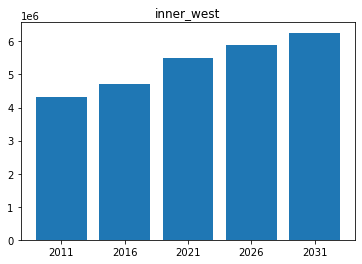

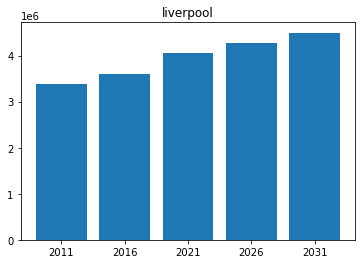

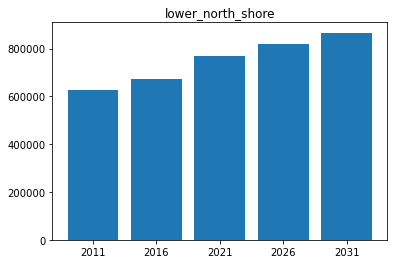

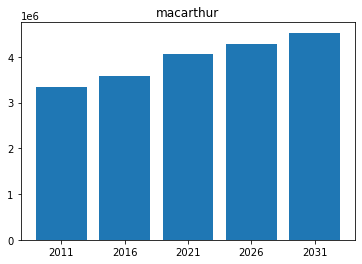

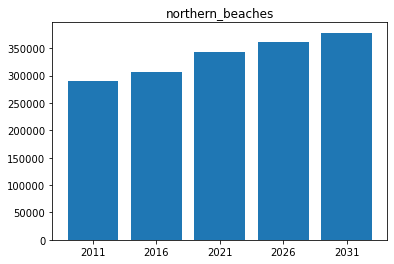

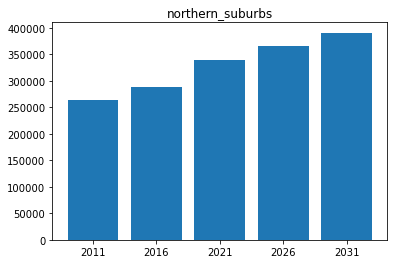

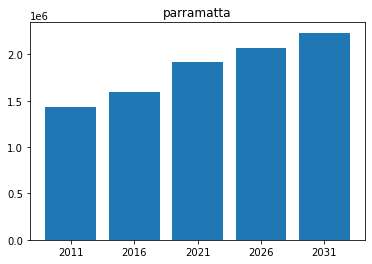

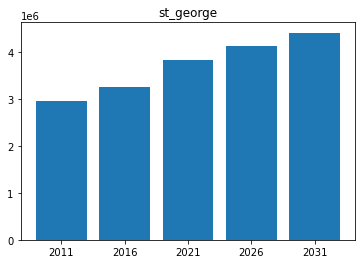

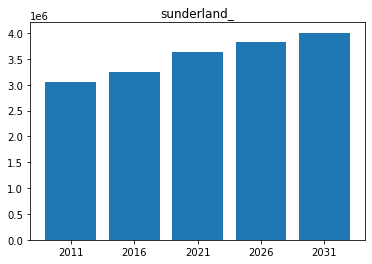

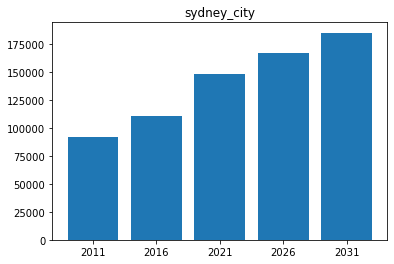

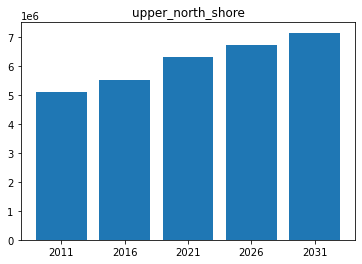

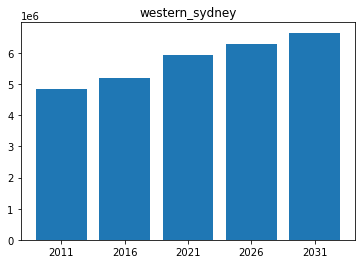

In [65]:
# reset the dataframe with index and column names as per requirement
postal_df_transposed, cols = reset_index_postal_df(df_postal_code_transp)

# regression model object
ransac_model_postal = RANSACRegressor()

# using the function to create a dataframe with regression results
ransac_prediction_df = create_dataframe_postal(ransac_model_postal, postal_df_transposed, cols)

# adding the index of years for dataframe
postal_df_transposed.index = ['2011', '2016']

# combining the original and prediction dataframe
df_with_ransac_results_postal = pd.concat([postal_df_transposed, ransac_prediction_df])


In [66]:
# adding suffix of model name for future identification
df_with_ransac_results_postal = df_with_ransac_results_postal.add_suffix('_ransac_model')
df_with_ransac_results_postal

,blue_mountains_ransac_model,canterbury_ransac_model,eastern_ransac_model,hawkesbury_ransac_model,hills_ransac_model,inner_west_ransac_model,liverpool_ransac_model,lower_north_shore_ransac_model,macarthur_ransac_model,northern_beaches_ransac_model,northern_suburbs_ransac_model,parramatta_ransac_model,st_george_ransac_model,sunderland__ransac_model,sydney_city_ransac_model,upper_north_shore_ransac_model,western_sydney_ransac_model
2011,986163.0,2879909.0,389095.0,5686890.0,5119559.0,4329774.0,3372270.0,626164.0,3344381.0,289195.0,263988.0,1435088.0,2962287.0,3060706.0,92381.0,5091092.0,4833118.0
2016,1057604.0,3118380.0,438895.0,6137340.0,5522766.0,4716249.0,3596856.0,674163.0,3580687.0,306995.0,289404.0,1594641.0,3253597.0,3249927.0,110970.0,5502991.0,5196942.0
2021,1200486.0,3595322.0,538495.0,7038240.0,6329180.0,5489199.0,4046028.0,770161.0,4053299.0,342595.0,340236.0,1913747.0,3836217.0,3628369.0,148148.0,6326789.0,5924590.0
2026,1271927.0,3833793.0,588295.0,7488690.0,6732387.0,5875674.0,4270614.0,818160.0,4289605.0,360395.0,365652.0,2073300.0,4127527.0,3817590.0,166737.0,6738688.0,6288414.0
2031,1343368.0,4072264.0,638095.0,7939140.0,7135594.0,6262149.0,4495200.0,866159.0,4525911.0,378195.0,391068.0,2232853.0,4418837.0,4006811.0,185326.0,7150587.0,6652238.0


#### Poisson Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


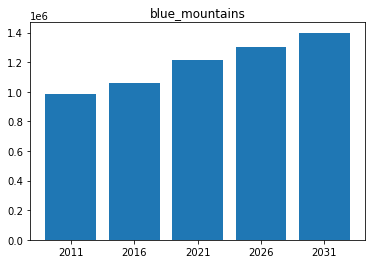

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


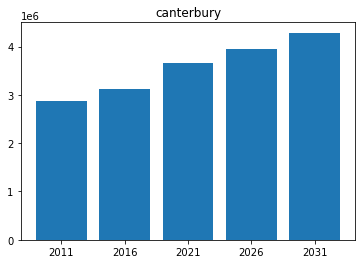

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


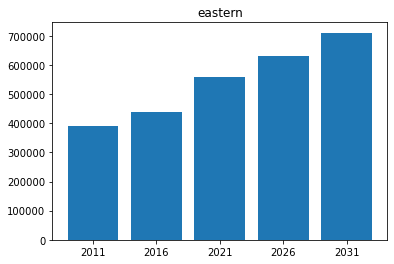

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


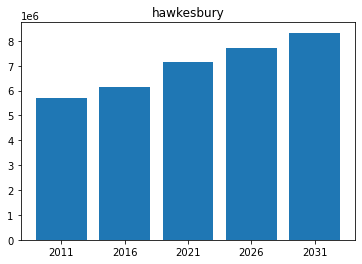

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


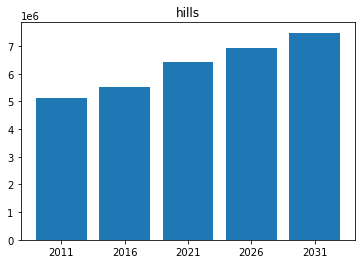

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


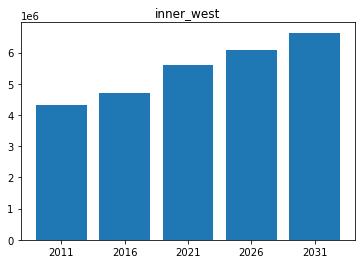

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


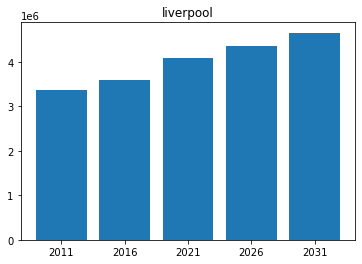

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


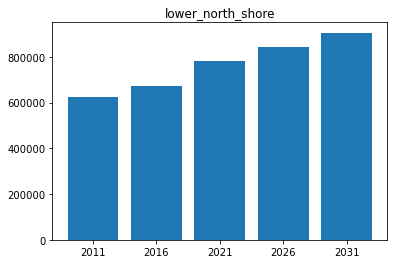

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


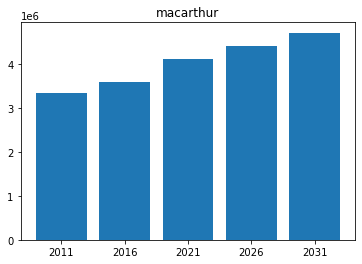

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


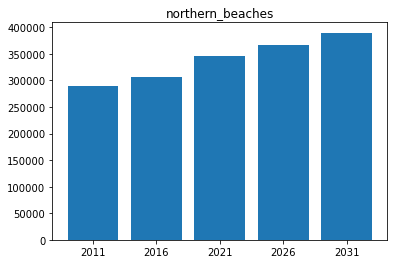

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


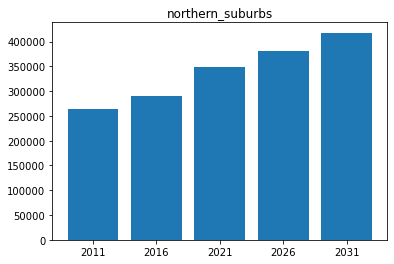

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


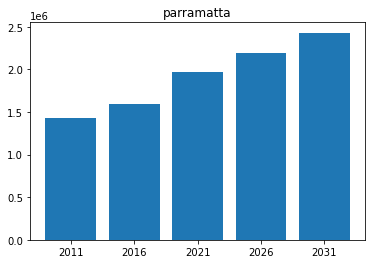

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


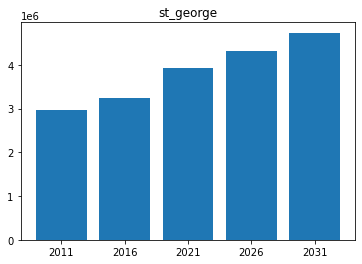

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


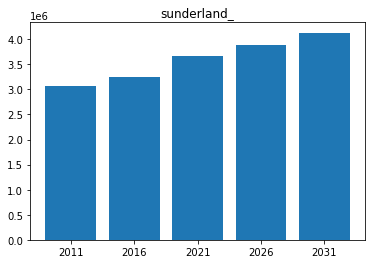

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


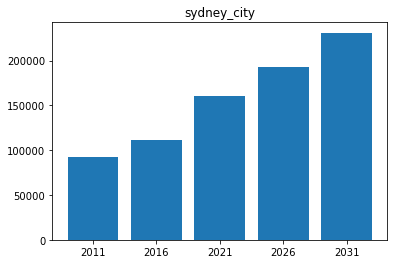

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


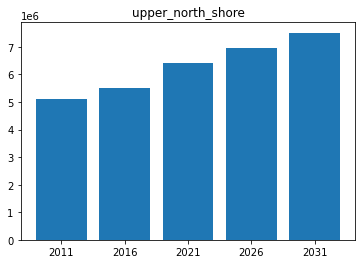

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


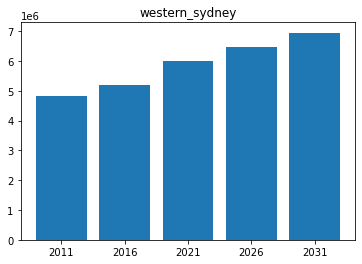

In [67]:
# reset the dataframe with index and column names as per requirement
postal_df_transposed, cols = reset_index_postal_df(df_postal_code_transp)

# regression model object
poisson_model_postal = PoissonRegressor()

# using the function to create a dataframe with regression results
poisson_prediction_df = create_dataframe_postal(poisson_model_postal, postal_df_transposed, cols)

# adding the index of years for dataframe
postal_df_transposed.index = ['2011', '2016']

# combining the original and prediction dataframe
df_with_poisson_results_postal = pd.concat([postal_df_transposed, poisson_prediction_df])


In [68]:
# adding suffix of model name for future identification
df_with_poisson_results_postal = df_with_poisson_results_postal.add_suffix('_poisson_model')
df_with_poisson_results_postal

,blue_mountains_poisson_model,canterbury_poisson_model,eastern_poisson_model,hawkesbury_poisson_model,hills_poisson_model,inner_west_poisson_model,liverpool_poisson_model,lower_north_shore_poisson_model,macarthur_poisson_model,northern_beaches_poisson_model,northern_suburbs_poisson_model,parramatta_poisson_model,st_george_poisson_model,sunderland__poisson_model,sydney_city_poisson_model,upper_north_shore_poisson_model,western_sydney_poisson_model
2011,9.861630e+05,2.879909e+06,389095.000000,5.686890e+06,5.119559e+06,4.329774e+06,3.372270e+06,626164.000000,3.344381e+06,289195.000000,263988.000000,1.435088e+06,2.962287e+06,3.060706e+06,92381.000000,5.091092e+06,4.833118e+06
2016,1.057604e+06,3.118380e+06,438895.000000,6.137340e+06,5.522766e+06,4.716249e+06,3.596856e+06,674163.000000,3.580687e+06,306995.000000,289404.000000,1.594641e+06,3.253597e+06,3.249927e+06,110970.000000,5.502991e+06,5.196942e+06
2021,1.216386e+06,3.656196e+06,558430.778772,7.148104e+06,6.426948e+06,5.595767e+06,4.091894e+06,781480.345483,4.104568e+06,345948.523049,347811.377363,1.968935e+06,3.924975e+06,3.664186e+06,160119.301653,6.429459e+06,6.008814e+06
2026,1.304505e+06,3.958947e+06,629903.212360,7.714294e+06,6.933122e+06,6.095244e+06,4.364405e+06,841384.835910,4.394587e+06,367241.417136,381297.141587,2.187841e+06,4.310955e+06,3.890715e+06,192337.273555,6.949640e+06,6.461141e+06
2031,1.399008e+06,4.286767e+06,710523.259148,8.325331e+06,7.479161e+06,6.639304e+06,4.655065e+06,905881.313831,4.705098e+06,389844.874235,418006.769315,2.431084e+06,4.734891e+06,4.131249e+06,231037.897473,7.511906e+06,6.947517e+06


#### SGD Regression Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


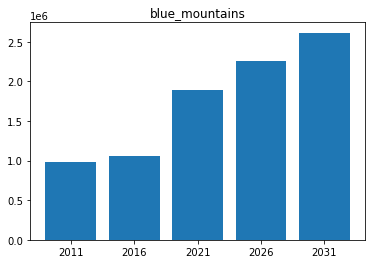

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


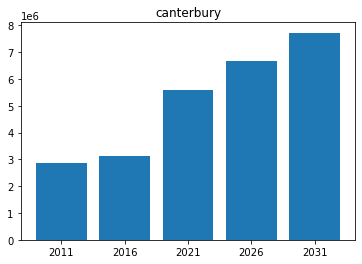

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


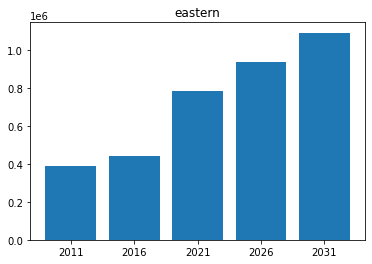

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


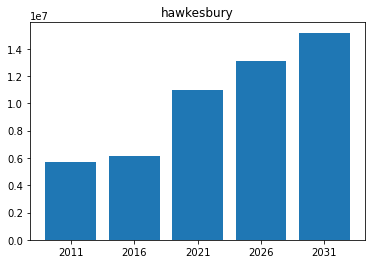

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


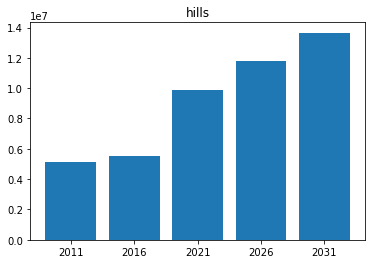

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


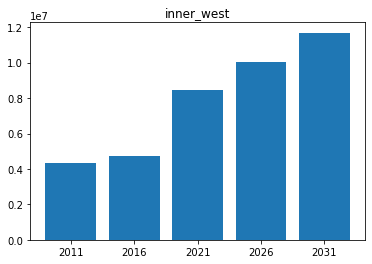

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


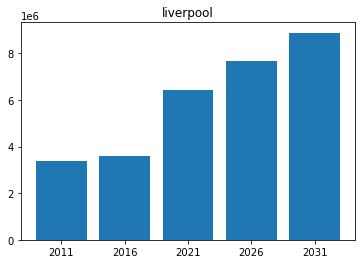

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


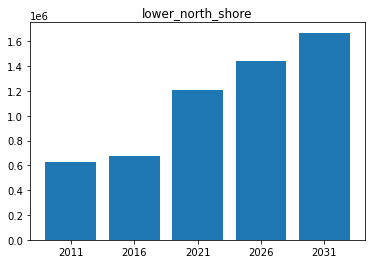

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


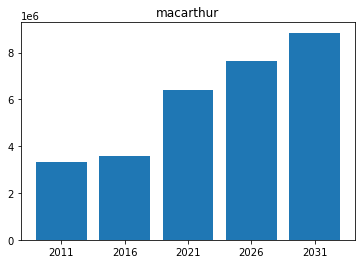

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


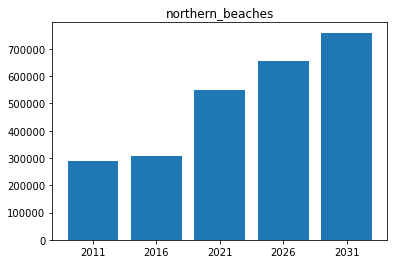

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


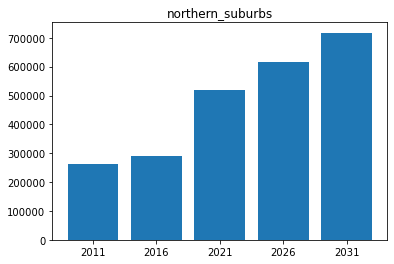

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


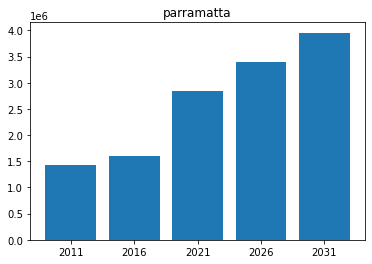

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


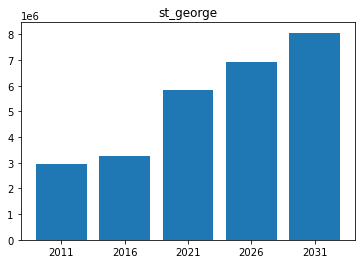

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


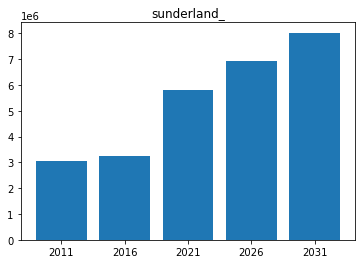

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


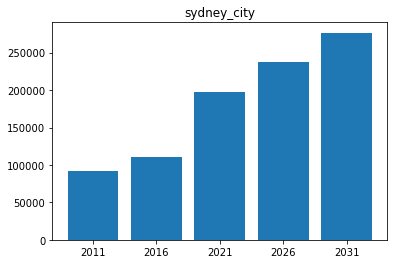

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


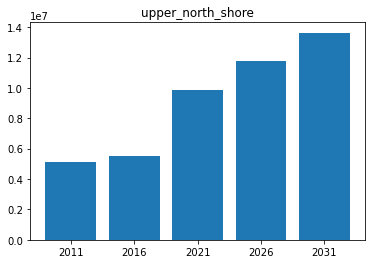

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


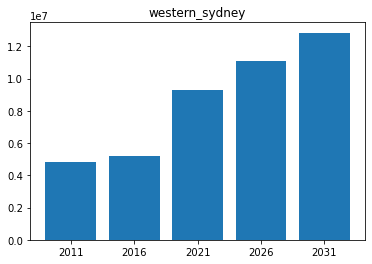

In [69]:
# reset the dataframe with index and column names as per requirement
postal_df_transposed, cols = reset_index_postal_df(df_postal_code_transp)

# regression model object
sgd_model_postal = SGDRegressor()

# using the function to create a dataframe with regression results
sgd_prediction_df = create_dataframe_postal(sgd_model_postal, postal_df_transposed, cols)

# adding the index of years for dataframe
postal_df_transposed.index = ['2011', '2016']

# combining the original and prediction dataframe
df_with_sgd_results_postal = pd.concat([postal_df_transposed, sgd_prediction_df])


In [70]:
# adding suffix of model name for future identification
df_with_sgd_results_postal = df_with_sgd_results_postal.add_suffix('_sgd_model')
df_with_sgd_results_postal

,blue_mountains_sgd_model,canterbury_sgd_model,eastern_sgd_model,hawkesbury_sgd_model,hills_sgd_model,inner_west_sgd_model,liverpool_sgd_model,lower_north_shore_sgd_model,macarthur_sgd_model,northern_beaches_sgd_model,northern_suburbs_sgd_model,parramatta_sgd_model,st_george_sgd_model,sunderland__sgd_model,sydney_city_sgd_model,upper_north_shore_sgd_model,western_sydney_sgd_model
2011,9.861630e+05,2.879909e+06,3.890950e+05,5.686890e+06,5.119559e+06,4.329774e+06,3.372270e+06,6.261640e+05,3.344381e+06,289195.000000,263988.000000,1.435088e+06,2.962287e+06,3.060706e+06,92381.000000,5.091092e+06,4.833118e+06
2016,1.057604e+06,3.118380e+06,4.388950e+05,6.137340e+06,5.522766e+06,4.716249e+06,3.596856e+06,6.741630e+05,3.580687e+06,306995.000000,289404.000000,1.594641e+06,3.253597e+06,3.249927e+06,110970.000000,5.502991e+06,5.196942e+06
2021,1.891182e+06,5.581170e+06,7.841642e+05,1.097177e+07,9.873259e+06,8.438827e+06,6.433288e+06,1.206891e+06,6.403346e+06,549922.865143,517691.253098,2.850895e+06,5.819630e+06,5.813875e+06,197767.187420,9.849810e+06,9.292023e+06
2026,2.252816e+06,6.653562e+06,9.371291e+05,1.307487e+07,1.176549e+07,1.006395e+07,7.660868e+06,1.438286e+06,7.627013e+06,654786.361395,617626.511771,3.403988e+06,6.943840e+06,6.921324e+06,237193.145024,1.174114e+07,1.107066e+07
2031,2.614449e+06,7.725954e+06,1.090094e+06,1.517797e+07,1.365773e+07,1.168907e+07,8.888449e+06,1.669682e+06,8.850679e+06,759649.857646,717561.770443,3.957081e+06,8.068050e+06,8.028774e+06,276619.102629,1.363247e+07,1.284929e+07


#### Huber Regresssion Model

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


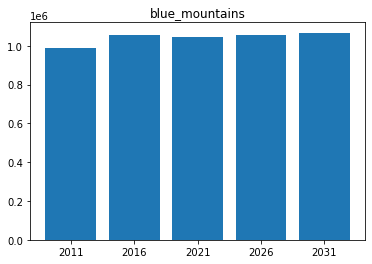

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


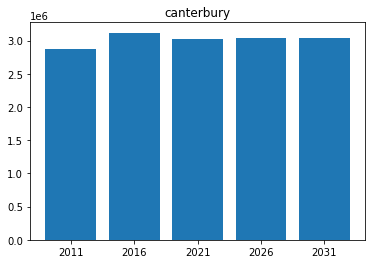

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


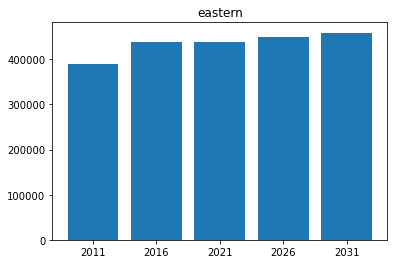

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


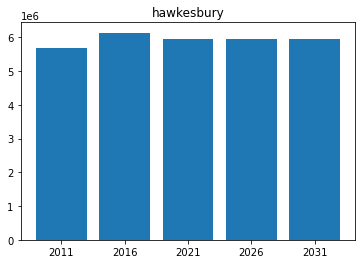

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


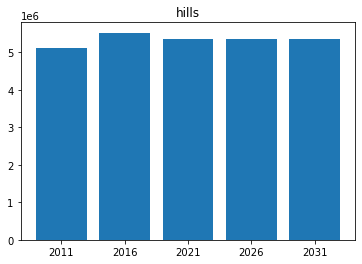

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


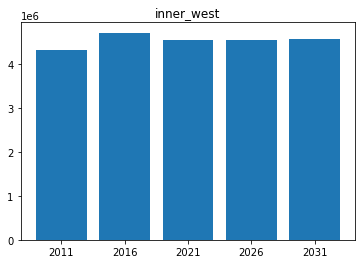

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


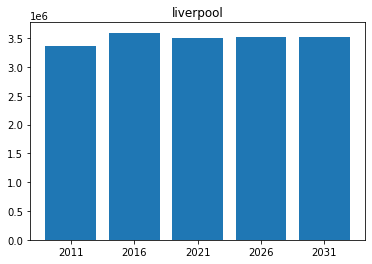

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


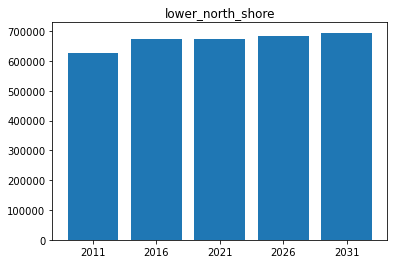

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


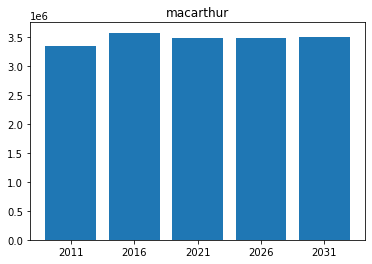

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_huber.py:86: RuntimeWarning: invalid value encountered in double_scalars
  squared_loss = weighted_loss / sigma
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_huber.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\linear_model\_huber.py:96: RuntimeWarning: invalid value encountered in multiply
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-pack

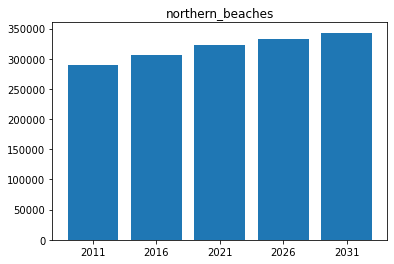

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


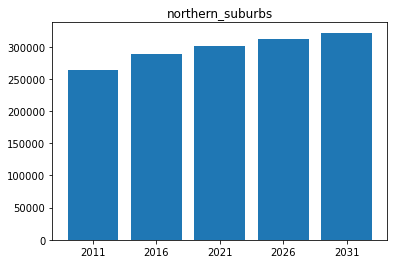

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


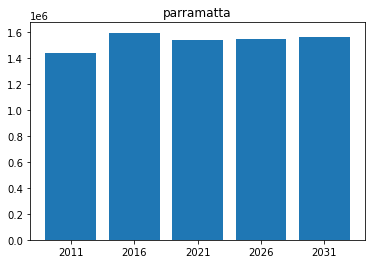

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


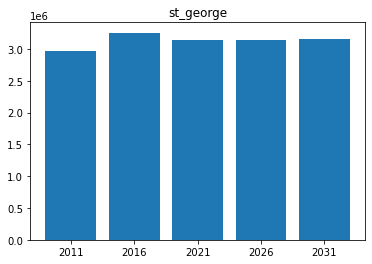

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


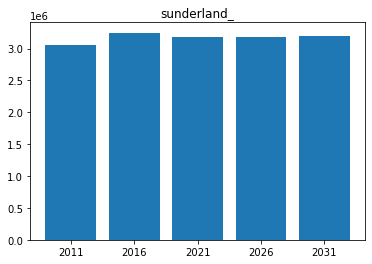

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


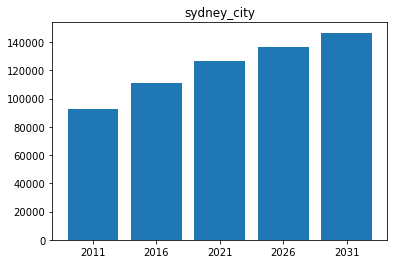

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


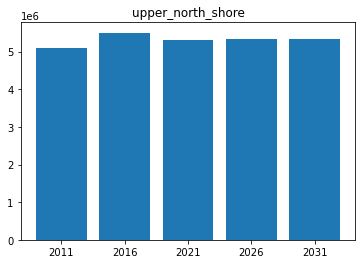

C:\Users\Arjun Janamatti\Anaconda3\envs\tf_nptel\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


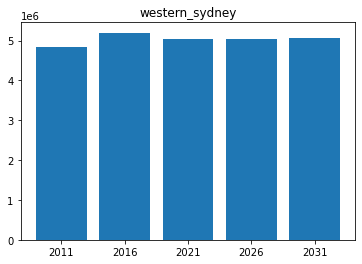

In [71]:
# reset the dataframe with index and column names as per requirement
postal_df_transposed, cols = reset_index_postal_df(df_postal_code_transp)

# regression model object
huber_model_postal = HuberRegressor()

# using the function to create a dataframe with regression results
huber_prediction_df = create_dataframe_postal(huber_model_postal, postal_df_transposed, cols)

# adding the index of years for dataframe
postal_df_transposed.index = ['2011', '2016']

# combining the original and prediction dataframe
df_with_huber_results_postal = pd.concat([postal_df_transposed, huber_prediction_df])


In [72]:
# adding suffix of model name for future identification
df_with_huber_results_postal = df_with_huber_results_postal.add_suffix('_huber_model')
df_with_huber_results_postal

,blue_mountains_huber_model,canterbury_huber_model,eastern_huber_model,hawkesbury_huber_model,hills_huber_model,inner_west_huber_model,liverpool_huber_model,lower_north_shore_huber_model,macarthur_huber_model,northern_beaches_huber_model,northern_suburbs_huber_model,parramatta_huber_model,st_george_huber_model,sunderland__huber_model,sydney_city_huber_model,upper_north_shore_huber_model,western_sydney_huber_model
2011,9.861630e+05,2.879909e+06,389095.000000,5.686890e+06,5.119559e+06,4.329774e+06,3.372270e+06,626164.000000,3.344381e+06,289195.000000,263988.000000,1.435088e+06,2.962287e+06,3.060706e+06,92381.000000,5.091092e+06,4.833118e+06
2016,1.057604e+06,3.118380e+06,438895.000000,6.137340e+06,5.522766e+06,4.716249e+06,3.596856e+06,674163.000000,3.580687e+06,306995.000000,289404.000000,1.594641e+06,3.253597e+06,3.249927e+06,110970.000000,5.502991e+06,5.196942e+06
2021,1.046884e+06,3.024145e+06,438995.002032,5.937115e+06,5.346163e+06,4.548011e+06,3.509563e+06,675163.491251,3.487534e+06,323094.999611,301696.089152,1.539865e+06,3.132941e+06,3.180317e+06,126675.516573,5.322041e+06,5.040029e+06
2026,1.056884e+06,3.034145e+06,448994.999714,5.947115e+06,5.356163e+06,4.558011e+06,3.519563e+06,685163.487359,3.497534e+06,333094.999130,311696.134560,1.549865e+06,3.142941e+06,3.190317e+06,136675.497952,5.332041e+06,5.050029e+06
2031,1.066884e+06,3.044145e+06,458994.997397,5.957115e+06,5.366163e+06,4.568011e+06,3.529563e+06,695163.483468,3.507534e+06,343094.998650,321696.179967,1.559865e+06,3.152941e+06,3.200317e+06,146675.479332,5.342041e+06,5.060029e+06


#### Plot to compare results

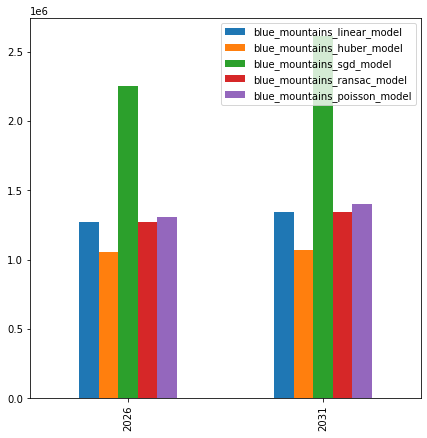

In [73]:
plot_comparison_results(0,
                        df_with_linear_results_postal, 
                        df_with_huber_results_postal, 
                        df_with_sgd_results_postal, 
                        df_with_ransac_results_postal, 
                        df_with_poisson_results_postal)

# CSV File download

In [74]:
def get_csv_file(df_linear, df_huber, df_poisson, df_sgd, df_ransac, category):
    a =  pd.concat([df_linear, 
                      df_huber, 
                      df_poisson, 
                      df_sgd, 
                      df_ransac],
                     axis = 1)
    return a.to_csv('{}_category.csv'.format(category))

### Marriage category csv results download

In [75]:
get_csv_file(df_with_huber_results_marriage, 
             df_with_linear_results_marriage, 
             df_with_poisson_results_marriage, 
             df_with_ransac_results_marriage, 
             df_with_sgd_results_marriage,
             'marriage')

### Age category csv results download

In [76]:
get_csv_file(df_with_huber_results_age, 
             df_with_linear_results_age, 
             df_with_poisson_results_age, 
             df_with_ransac_results_age, 
             df_with_sgd_results_age,
             'age')

### Gender category csv results download

In [77]:
get_csv_file(df_with_huber_results_gender, 
             df_with_linear_results_gender, 
             df_with_poisson_results_gender, 
             df_with_ransac_results_gender, 
             df_with_sgd_results_gender,
             'gender')

### Postal code category csv results download

In [78]:
get_csv_file(df_with_huber_results_postal, 
             df_with_linear_results_postal, 
             df_with_poisson_results_postal, 
             df_with_ransac_results_postal, 
             df_with_sgd_results_postal,
             'postal_code')

### Income category csv results download

In [79]:
get_csv_file(df_with_huber_results_income, 
             df_with_linear_results_income, 
             df_with_poisson_results_income, 
             df_with_ransac_results_income, 
             df_with_sgd_results_income,
             'income')